# Step 2: Normalize your data using sctransform

Use this notebook to normalize your data using the [sctransform](https://satijalab.org/seurat/articles/sctransform_vignette) package. 

Please note that the sctransform package is written in R. Therefore, in order to run this notebook you will first need to [install R]() on your system, as well as [sctransform version 0.4.1](https://github.com/satijalab/sctransform) and it's corresponding dependencies (including the optional dependency [glmGamPoi](https://github.com/const-ae/glmGamPoi)). 

Also note that your raw data input should be a csv file arranged using [tidy format](https://tidyr.tidyverse.org/articles/tidy-data.html). At a minimum your input csv should have five columns:
1. A column that corresponds to the first mode of your tensor. In metatranscriptomic data this column might indicate gene ID.
    - This first mode should generally be the longest in your tensor, and the one that corresponds to the variable you want clustered (e.g. genes in the case of metatranscriptomics data). The sparsity penalty (`lambda`) will be applied to this mode.
1. A column that corresponds to the second mode of your tensor. In metatranscriptomic data this column might indicate taxon ID.
1. A column that corresponds to the third mode of your tensor. This column should indicate sample ID.
    - **IMPORTANT: Sample IDs should be identical for different replicates of the same sample condition (see example below).**
1. A column that indicates the replicate ID of the sample.
1. A column that corresponds to the data variable. For raw metatranscriptomic data this column might contain read counts.

Here's a snippet of how an example csv might be arranged:

| gene_id | taxon_id   | sample_id | replicate | residual |
|---------|------------|-----------|-----------|----------|
| K03839  | P. marinus | sample1   | A         | 3.02     |
| K03839  | P. marinus | sample1   | B         | 3.31     |
| K03839  | P. marinus | sample1   | C         | 3.18     |
| K03839  | P. marinus | sample2   | A         | -1.24    |
| ...     | ...        | ...       | ...       | ...      |
| K03320  | S. marinus | sample9   | C         | 0.05     |

In [1]:
# imports

# python packages
import math
import numpy as np
import os
import pandas as pd
import rpy2
import seaborn as sns

from matplotlib import pyplot as plt

# rpy2 imports
from rpy2 import robjects as ro
from rpy2.robjects.packages import importr
from rpy2.ipython.ggplot import image_png
from rpy2.robjects import pandas2ri

# load rpy2 extension for ipython
pandas2ri.activate()
%load_ext rpy2.ipython


/Users/blasks/Library/Caches/pypoetry/virtualenvs/barnacle-boilerplate-FgLDbbZs-py3.11/lib/python3.11/site-packages/rpy2/robjects/lib/ggplot2.py:70: UserWarning: This was designed against ggplot2 versions starting with 3.3. but you have 3.5.0
  warnings.warn(


In [2]:
# install & import sctransform and other r package dependencies

# check if sctransform is installed
if not ro.packages.isinstalled('sctransform'):
    # select CRAN mirror
    utils = importr('utils')
    utils.chooseCRANmirror(ind=1)
    # install sctransform
    utils.install_packages(ro.vectors.StrVector(['sctransform']))

# import sctransform and R Matrix package
sctransform = importr('sctransform')
rmatrix = importr('Matrix')

# check sctransform version (should be 0.4.1)
print(f'Installed sctransform version: {sctransform.__version__}')
if not sctransform.__version__ == '0.4.1':
    raise Exception('Please ensure that the installed sctransform is version 0.4.1')
    
# check that glmGamPoi depencency is installed
if not ro.packages.isinstalled('glmGamPoi'):
    raise Exception('Please install glmGamPoi: https://github.com/const-ae/glmGamPoi')


Installed sctransform version: 0.4.1


### Input data

In this step you will enter the variables necessary to:
1. Locate your input data
1. Configure your data tensor (i.e. which three variables correspond to the three different modes or axes)
1. Configure your normalization scheme

When it comes to normalization, there are several parameters you need to define:
- You will normalize by one of the variables that corresponds to a mode in your data tensor. You can think of this as the variable that defines the "within" groups. For example if I am normalizing by taxa, then the normalization procedure will be applied independently within each taxon in the dataset. Put another way, you can think of each taxon as a slab of your data tensor (i.e. a matrix), and the normalization will be applied independently to each slab.
- For each slab, you will define which of the remaining two modes best corresponds to samples, and which to genes. For example, in metatranscriptomic data annotated with KEGG orthologies, the sample ID would be the sample mode, and the KEGG ID would be the gene mode. Additionally, if you want to account for batch effects in your data, the batch variable should relate to your sample mode.
- You will define two thresholds that will apply to each slab (e.g. taxon):
    1. Sample threshold: each gene must be detected in at least this many samples. Genes that fall below the threshold will be removed. Default is 3.
    1. Detection threshold: each sample must contain non-zero values for at least this proportion of genes. Samples that fall below the threshold will be removed. Default is 0.01 (1%).
    - Note that data removed due to thresholding is preserved, saved, and displayed at the end of this notebook so it can be used for troubleshooting or to refine the thresholds and normalization work flow.
- If you want the normalization model to correct for batch effects, you will need to prepare a second csv file with columns corresponding to the sample mode in your data (including both sample ID and replicate), and with an additional column indicating the batch ID. For example, you might have a csv with the following headers: `['sample_id', 'replicate', 'batch_id']`. This file should include each unique combination of sample ID and replicate in your dataset, and the batch membership of each sample replicate should be indicated in the batch ID column.


In [3]:
# USER INPUTS -- edit these variables as needed

# data inputs
datapath = 'data/example-data.csv'  # Enter the filepath of your input data file
mode0 = 'KOfam'  # Enter the column name that will correspond to the first mode of your tensor
mode1 = 'phylum'  # Enter the column name that will correspond to the second mode of your tensor
mode2 = 'sample_name'  # Enter the column name that will correspond to the third mode of your tensor
rep = 'replicate'  # Enter the column name that corresponds to replicate IDs
data = 'counts'  # Enter the column name that corresponds to your data:
outdir = 'data/barnacle/normalization'  # Enter the filepath of the output directory where you want files saved

# normalization parameters
norm_mode = 'phylum'  # Which mode do you want to normalize by? (enter name of mode)
sample_mode = 'sample_name'  # Which mode corresponds to your sample variable? (enter name of mode)
sample_thold = 3 # Each {gene_mode} must be detected in what minimum number of unique {sample_mode}s? (Default is 3)
gene_thold = 0.01 # Each {sample_mode} must contain what minimum proportion of nonzero {gene_mode}s? (Default is 0.01)
save_data = True  # Would you like to save the data output for each normalization? (Enter True/False)
save_plots = True  # Would you like to save the diagnostic plots for each normalization? (Enter True/False)
correction = True  # Would you like to correct for batch effects? (Enter True/False)
metadata_path = 'data/metadata.csv'  # Enter the filepath of your batch metadata file
batch_id = 'batch_id'  # Enter the column name that corresponds to the batch ID

# check output directory exists
if not os.path.exists(outdir):
    os.makedirs(outdir)

# check data file exists
if datapath and not os.path.isfile(datapath):
    raise Exception(f'Unable to find the file "{datapath}"')


In [4]:
# check the dataframes

# read in csv
df = pd.read_csv(datapath)

# check column names match inputs
for column in [mode0, mode1, mode2, rep, data]:
    if column not in df.columns:
        raise Exception(f'Column name "{column}" not found in headers of file {datapath}')

# define gene mode
gene_mode = [m for m in [mode0, mode1, mode2] if m not in [norm_mode, sample_mode]][0]

# tidy up dataframe
df = df[[mode0, mode1, mode2, rep, data]]

# make a unique identifier that combines sampleID and replicateID
df['sample_rep_id'] = df[sample_mode].astype(str) + '_' +  df[rep].astype(str)
display(df)

# read in metadata if using for batch correction
if correction:
    # check data file exists
    if not os.path.isfile(metadata_path):
        raise Exception(f'Unable to find the file "{metadata_path}"')
    # read in metadata file
    meta_df = pd.read_csv(metadata_path)
    # Batch id name cannot end in "y" or sctransform freaks out
    batch_id_new = batch_id[:-1] if batch_id[-1] == 'y' else batch_id
    meta_df[batch_id_new] = meta_df[batch_id]
    batch_id = batch_id_new
    
    # check for sample, replicate, and batch columns
    if sample_mode not in meta_df.columns:
        raise Exception(f'Column name "{sample_mode}" not found in headers of file {metadata_path}. Columns found: {meta_df.columns}')
    if rep not in meta_df.columns:
        raise Exception(f'Column name "{rep}" not found in headers of file {metadata_path}. Columns found: {meta_df.columns}')
    if not (meta_df[[sample_mode, rep]].drop_duplicates().reset_index(drop=True) == \
            df[[sample_mode, rep]].drop_duplicates().reset_index(drop=True)).all().all():
        raise Exception(f'Files {datapath} and {metadata_path} have different values for columns {sample_mode} and {rep}.')  
    if batch_id not in meta_df.columns:
        raise Exception(f'Column name "{batch_id}" not found in headers of file {metadata_path}. Columns found: {meta_df.columns}')

    # clean up metadata dataframe
    meta_df['sample_rep_id'] = meta_df[sample_mode].astype(str) + '_' + meta_df[rep].astype(str)
    meta_df = meta_df[['sample_rep_id', sample_mode, rep, batch_id]]
    display(meta_df)


KOfam           phylum      sample_name replicate    counts  \
0        K00070  Acidobacteriota  G3.UW.ALL.L25S1         A   4.00000   
1        K00078  Acidobacteriota  G3.UW.ALL.L25S1         A   5.83841   
2        K00311  Acidobacteriota  G3.UW.ALL.L25S1         A   0.00000   
3        K00406  Acidobacteriota  G3.UW.ALL.L25S1         A   3.00000   
4        K00410  Acidobacteriota  G3.UW.ALL.L25S1         A  19.03930   
...         ...              ...              ...       ...       ...   
3181481  K24743    Xanthophyceae  G3.UW.ALL.L40S2         C   1.40753   
3181482  K25440    Xanthophyceae  G3.UW.ALL.L40S2         C   2.05893   
3181483  K25458    Xanthophyceae  G3.UW.ALL.L40S2         C   0.00000   
3181484  K25547    Xanthophyceae  G3.UW.ALL.L40S2         C   0.00000   
3181485  K25866    Xanthophyceae  G3.UW.ALL.L40S2         C   0.00000   

             sample_rep_id  
0        G3.UW.ALL.L25S1_A  
1        G3.UW.ALL.L25S1_A  
2        G3.UW.ALL.L25S1_A  
3        G3.UW.ALL.L25S1_A  
4        G3.UW.ALL.L25S1_A  
...                    ...  
3181481  G3.UW.ALL.L40S2_C  
3181482  G3.UW.ALL.L40S2_C  
3181483  G3.UW.ALL.L40S2_C  
3181484  G3.UW.ALL.L40S2_C  
3181485  G3.UW.ALL.L40S2_C  

[3181486 rows x 6 columns]

sample_rep_id      sample_name replicate  batch_id
0   G3.UW.ALL.L25S1_A  G3.UW.ALL.L25S1         A         1
1   G3.UW.ALL.L31S2_A  G3.UW.ALL.L31S2         A         1
2   G3.UW.ALL.L32S1_A  G3.UW.ALL.L32S1         A         1
3   G3.UW.ALL.L32S3_A  G3.UW.ALL.L32S3         A         2
4   G3.UW.ALL.L35S1_A  G3.UW.ALL.L35S1         A         2
5   G3.UW.ALL.L35S2_A  G3.UW.ALL.L35S2         A         2
6   G3.UW.ALL.L37S1_A  G3.UW.ALL.L37S1         A         2
7   G3.UW.ALL.L38S1_A  G3.UW.ALL.L38S1         A         2
8   G3.UW.ALL.L40S1_A  G3.UW.ALL.L40S1         A         2
9   G3.UW.ALL.L40S2_A  G3.UW.ALL.L40S2         A         1
10  G3.UW.ALL.L25S1_B  G3.UW.ALL.L25S1         B         1
11  G3.UW.ALL.L29S1_B  G3.UW.ALL.L29S1         B         1
12  G3.UW.ALL.L31S2_B  G3.UW.ALL.L31S2         B         1
13  G3.UW.ALL.L32S3_B  G3.UW.ALL.L32S3         B         2
14  G3.UW.ALL.L35S1_B  G3.UW.ALL.L35S1         B         2
15  G3.UW.ALL.L35S2_B  G3.UW.ALL.L35S2         B         2
16  G3.UW.ALL.L37S1_B  G3.UW.ALL.L37S1         B         2
17  G3.UW.ALL.L38S1_B  G3.UW.ALL.L38S1         B         2
18  G3.UW.ALL.L40S1_B  G3.UW.ALL.L40S1         B         2
19  G3.UW.ALL.L40S2_B  G3.UW.ALL.L40S2         B         1
20  G3.UW.ALL.L25S1_C  G3.UW.ALL.L25S1         C         1
21  G3.UW.ALL.L29S1_C  G3.UW.ALL.L29S1         C         1
22  G3.UW.ALL.L31S2_C  G3.UW.ALL.L31S2         C         1
23  G3.UW.ALL.L32S1_C  G3.UW.ALL.L32S1         C         2
24  G3.UW.ALL.L32S3_C  G3.UW.ALL.L32S3         C         2
25  G3.UW.ALL.L35S1_C  G3.UW.ALL.L35S1         C         2
26  G3.UW.ALL.L35S2_C  G3.UW.ALL.L35S2         C         2
27  G3.UW.ALL.L37S1_C  G3.UW.ALL.L37S1         C         2
28  G3.UW.ALL.L38S1_C  G3.UW.ALL.L38S1         C         2
29  G3.UW.ALL.L40S1_C  G3.UW.ALL.L40S1         C         2
30  G3.UW.ALL.L40S2_C  G3.UW.ALL.L40S2         C         1

### Run sctransform on each slab of data

In this step you'll run the sctransform model on your data. If you selected it in the first step, the data and/or plots resulting from each normalization run will be saved to the designated output directory.

In [5]:
# helper functions for running normalization model

# function to threshold sparsity of pandas dataframes
def sparsity_thold_df(df, thold, axis=0):
    """Apply a sparsity threshold to a pandas.DataFrame so that only columns or rows with 
    greater than or equal to the threshold amount of nonzero values are retained.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe object.
    thold : {int, float}
        Threshold. If parameter is an int, then retained vectors must contain at least that number of 
        nonzero values. If parameter is a float, then at least this proportion of the vector must be nonzero.
    axis : int
        Axis to which threshold is applied. 
            
    Returns
    -------
    df : pandas.DataFrame
        Thresholded dataframe.
    dropped_data_df : pandas.DataFrame
        Data removed from the input dataframe as a result of the threshold
    """
    if type(thold) is float:
        thold = math.ceil(df.shape[axis] * thold)
    elif type(thold) is not int:
        raise Exception('Parameter `thold` must be either an int or float type value.')
    mask = (df != 0).sum(axis).ge(thold)
    if axis == 0:
        output_df = df.loc[:, mask]
        dropped_df = df.loc[:, ~mask]
    elif axis == 1:
        output_df = df.loc[mask, :]
        dropped_df = df.loc[~mask, :]
    else:
        raise Exception('Invalid value for `axis` parameter.')
    return output_df, dropped_df


# function to calculate 0-sensitive geometric mean
def geometric_mean(vector, pseudocount=1):
    return np.exp(np.mean(np.log(vector + pseudocount))) - pseudocount


# function to convert pandas dataframe to r matrix
def pandas_dataframe_to_r_matrix(df, dtype=float):
    """
    Function to convert pandas DataFrame objects to R matrix objects.
    """
    if dtype is float:
        vector = ro.vectors.FloatVector(df.values.flatten().tolist())
    elif dtype is str:
        vector = ro.vectors.StrVector(df.values.flatten().tolist())
    elif dtype is int:
        vector = ro.vectors.FloatVector(df.values.flatten().tolist())
    else:
        raise ValueError('The dtype {} is not recognized'.format(dtype))
    matrix = rmatrix.Matrix(
        data=vector, 
        nrow=df.shape[0], 
        ncol=df.shape[1], 
        byrow=True, 
        dimnames=[df.index.to_list(), df.columns.to_list()], 
        sparse=True
    )
    return matrix
    

Normalizing slab 1 of 105: Acidobacteriota (25 samples, 205 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 205

R[write to console]: Total overdispersed genes: 204

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 205 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 204 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  2 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 11 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.272707461796

R[write to console]: Second step: Get residuals using fitted parameters for 205 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.039315 secs



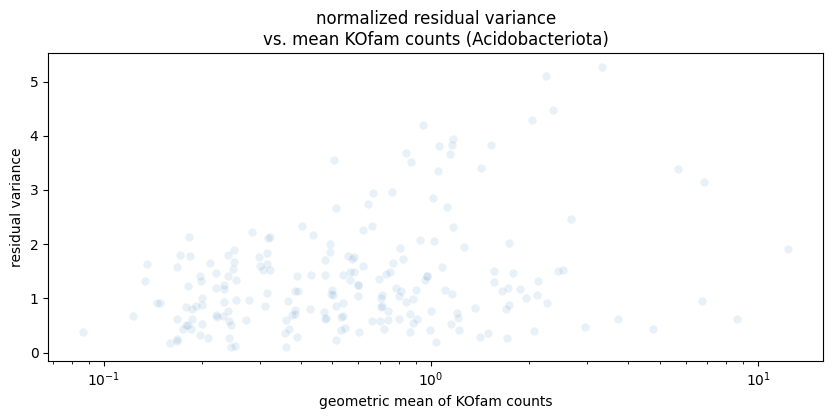

Normalizing slab 2 of 105: Actinomycetota (25 samples, 1940 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 1940

R[write to console]: Total overdispersed genes: 1928

R[write to console]: Excluding 12 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 1940 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 1928 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  21 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 103 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 1940 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.750754 secs

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: The `guide` argument in `scale_*()` cannot be `FALSE`. This was deprecated in
ggplot2 3.3.4.
ℹ Please use "none" instead.
ℹ The deprecated feature was likely used in the sctransform package.
  Please report the issue at <https://github.com/satijalab/sctransform/issues>.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 



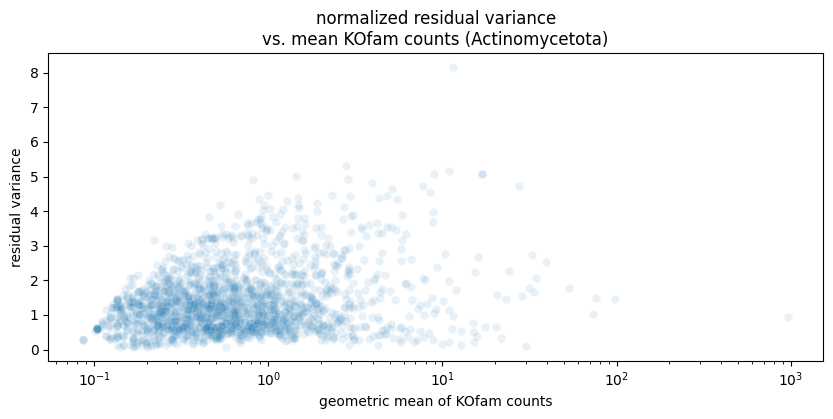

Normalizing slab 3 of 105: Annelida (28 samples, 1404 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 1404

R[write to console]: Total overdispersed genes: 1402

R[write to console]: Excluding 2 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 1404 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 1402 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 53 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1.191435557841

R[write to console]: Second step: Get residuals using fitted parameters for 1404 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.42409 secs



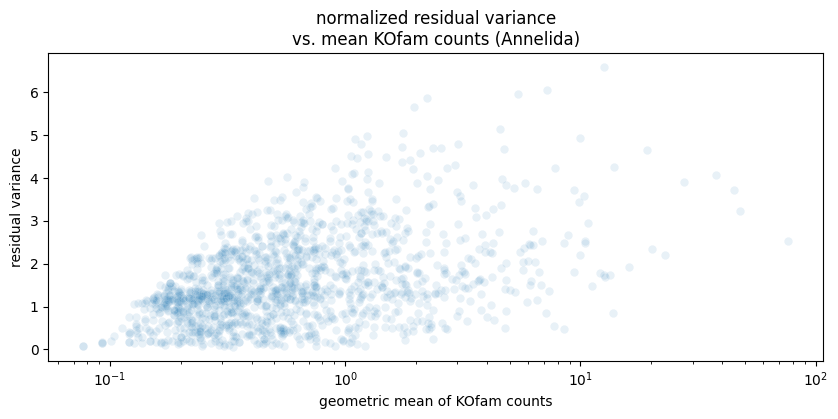

Normalizing slab 4 of 105: Apicomplexa (28 samples, 510 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 510

R[write to console]: Total overdispersed genes: 510

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 510 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 510 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  2 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 43 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 510 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.7166162 secs



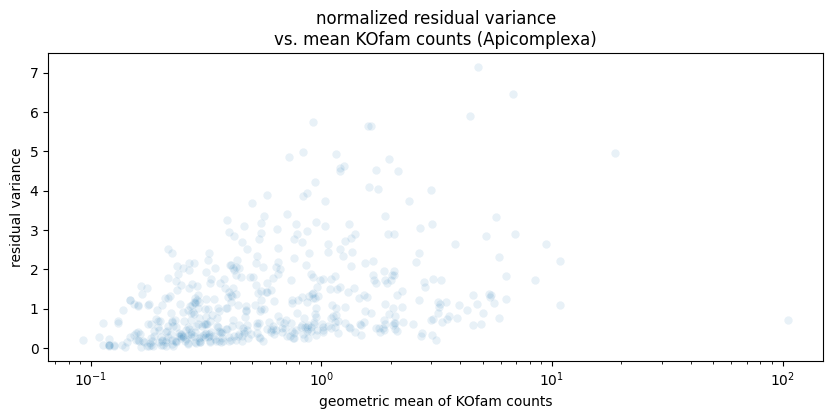

Normalizing slab 5 of 105: Aquificota (25 samples, 44 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 44

R[write to console]: Total overdispersed genes: 44

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 44 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 44 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 1 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 44 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.3711729 secs



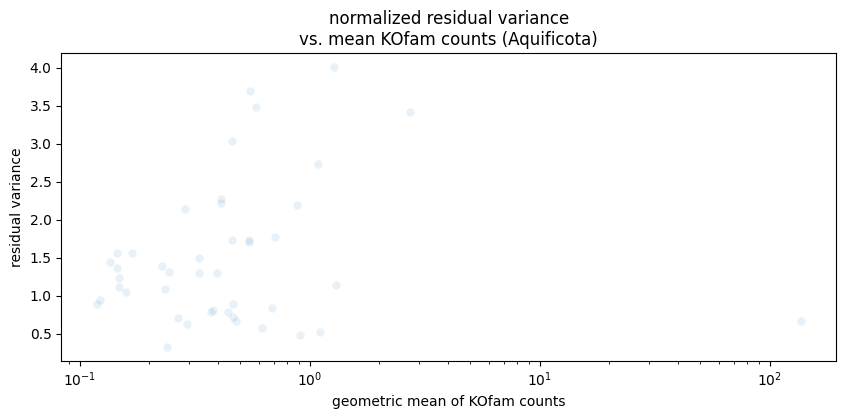

Normalizing slab 6 of 105: Armatimonadota (25 samples, 42 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 42

R[write to console]: Total overdispersed genes: 42

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 42 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 42 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 1 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 42 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.3566449 secs



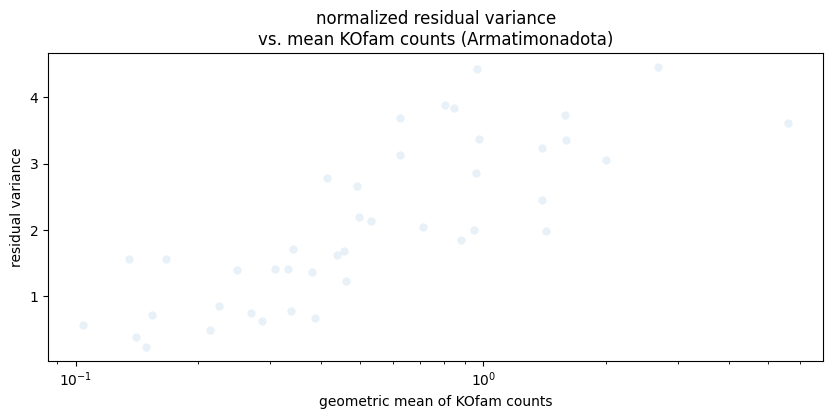

Normalizing slab 7 of 105: Arthropoda (28 samples, 8910 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 8910

R[write to console]: Total overdispersed genes: 8909

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 8910 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 37 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  29.16

R[write to console]: Second step: Get residuals using fitted parameters for 8910 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.259911 secs



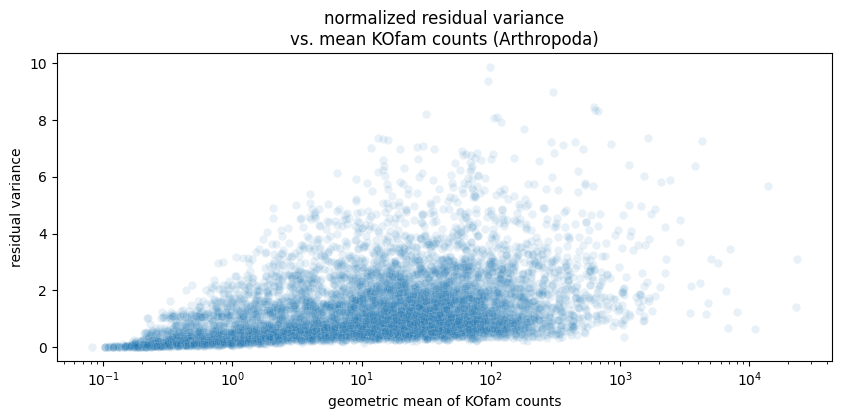

Normalizing slab 8 of 105: Ascomycota (28 samples, 41 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 41

R[write to console]: Total overdispersed genes: 41

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 41 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 41 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 41 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.3871319 secs



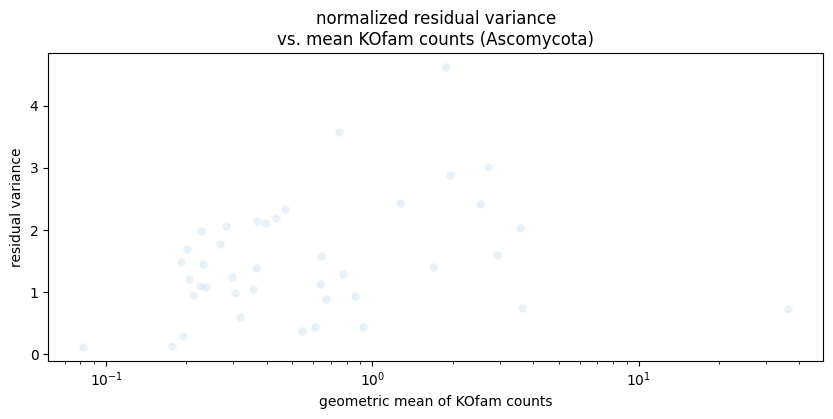

Normalizing slab 9 of 105: Atribacterota (25 samples, 33 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 33

R[write to console]: Total overdispersed genes: 33

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 33 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 33 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  2 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 1 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.16

R[write to console]: Second step: Get residuals using fitted parameters for 33 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.3625779 secs



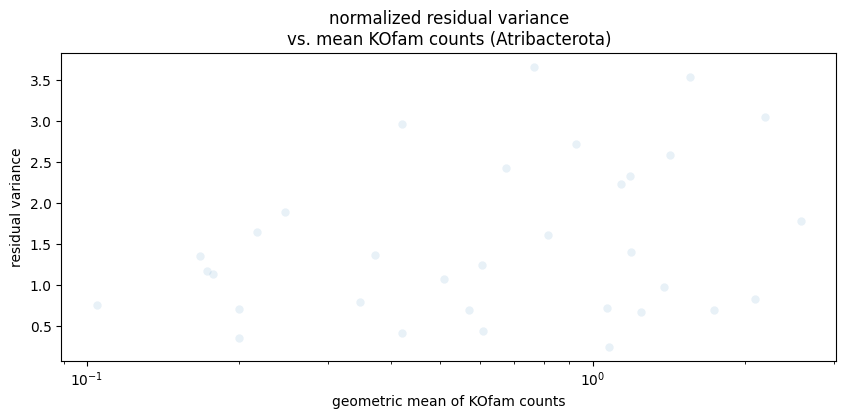

Normalizing slab 10 of 105: Bacillariophyta (28 samples, 7076 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 7076

R[write to console]: Total overdispersed genes: 7075

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 7076 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  17 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 85 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  6.76

R[write to console]: Second step: Get residuals using fitted parameters for 7076 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.130292 secs



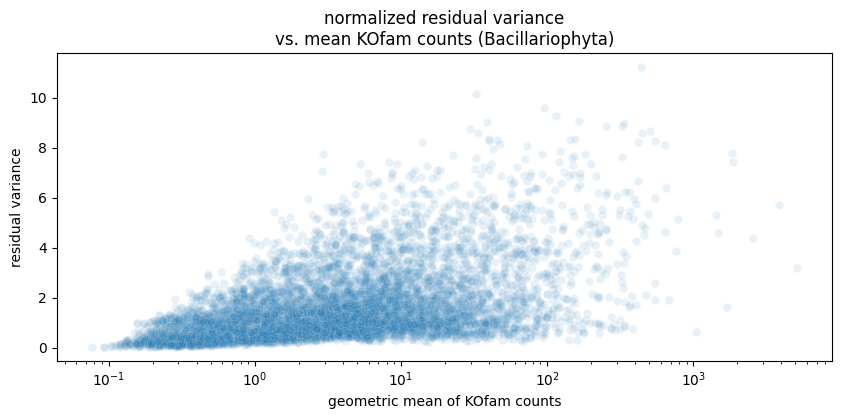

Normalizing slab 11 of 105: Bacillota (25 samples, 1604 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 1604

R[write to console]: Total overdispersed genes: 1592

R[write to console]: Excluding 12 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 1604 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 1592 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  16 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 103 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 1604 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.50419 secs



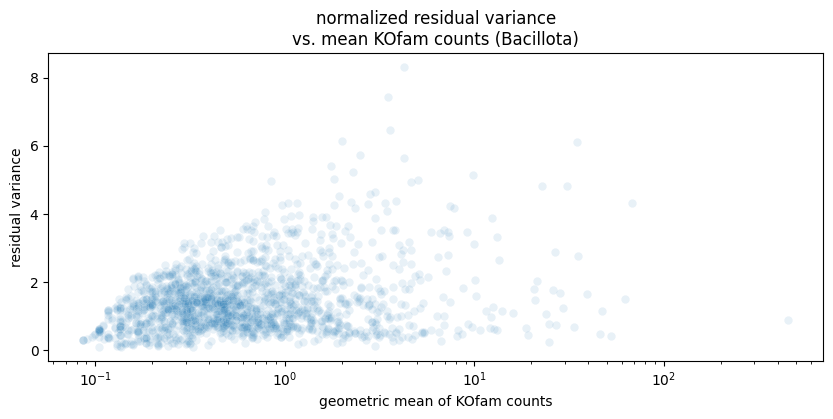

Normalizing slab 12 of 105: Bacteroidota (25 samples, 9711 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 9711

R[write to console]: Total overdispersed genes: 9698

R[write to console]: Excluding 13 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 9711 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  5 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 50 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  19.518388233444

R[write to console]: Second step: Get residuals using fitted parameters for 9711 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.181736 secs



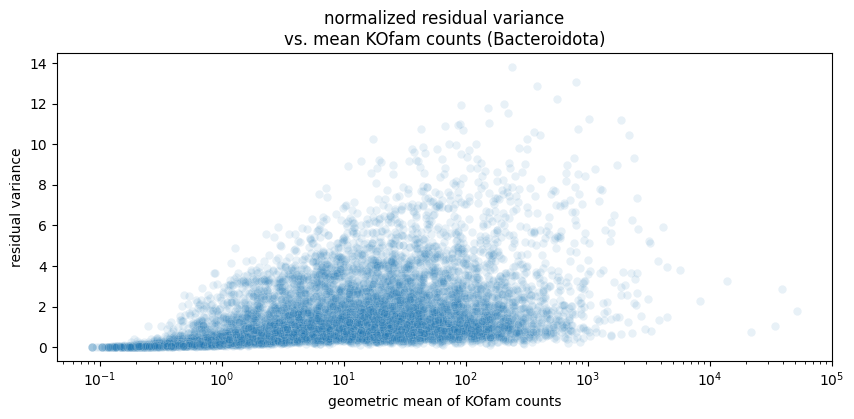

Normalizing slab 13 of 105: Balneolota (25 samples, 81 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 81

R[write to console]: Total overdispersed genes: 79

R[write to console]: Excluding 2 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 81 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 79 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  3 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 9 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 81 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.414793 secs



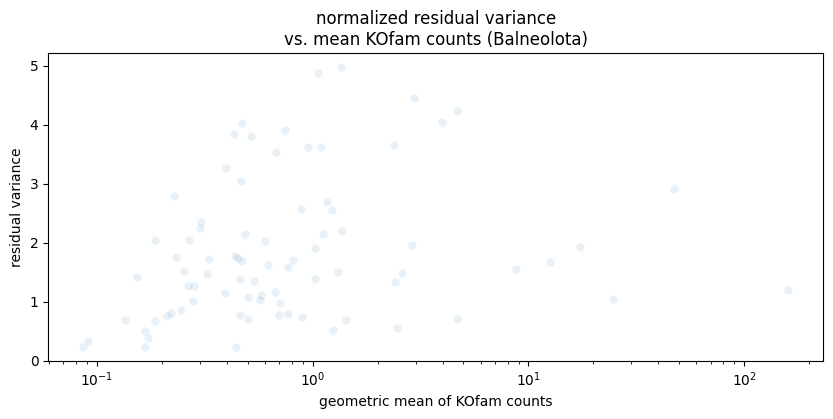

Normalizing slab 14 of 105: Basidiomycota (25 samples, 11 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 11

R[write to console]: Total overdispersed genes: 11

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 11 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 11 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 11 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.344496 secs



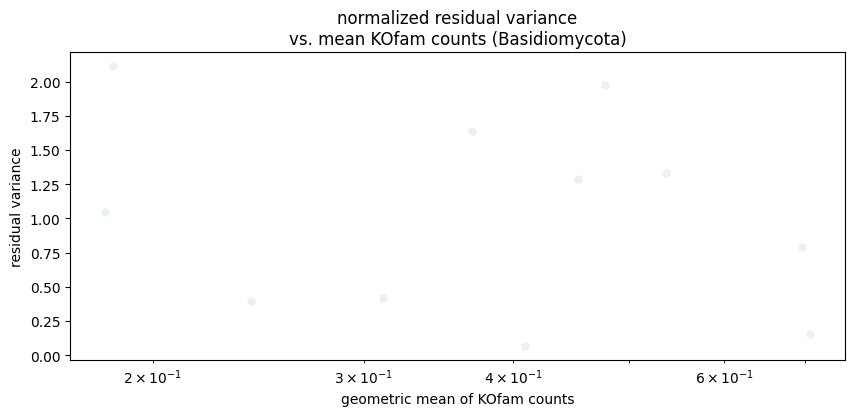

Normalizing slab 15 of 105: Bdellovibrionota (25 samples, 346 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 346

R[write to console]: Total overdispersed genes: 343

R[write to console]: Excluding 3 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 346 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 343 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 14 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 346 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5855541 secs



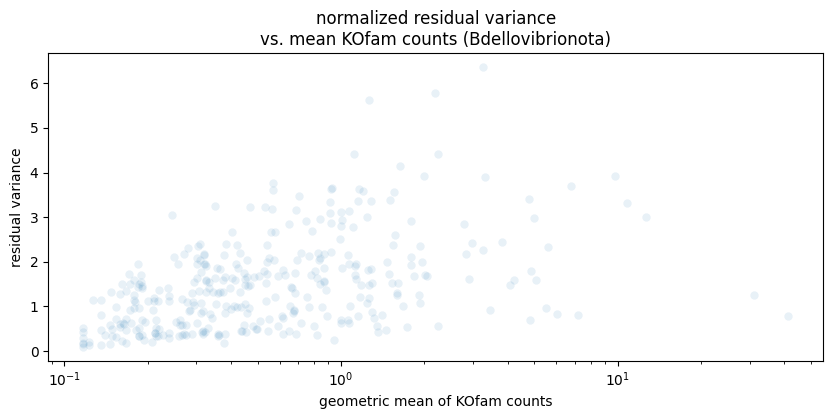

Normalizing slab 16 of 105: Bigyra (28 samples, 2659 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2659

R[write to console]: Total overdispersed genes: 2658

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2659 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  4 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 57 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1.44

R[write to console]: Second step: Get residuals using fitted parameters for 2659 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.852894 secs



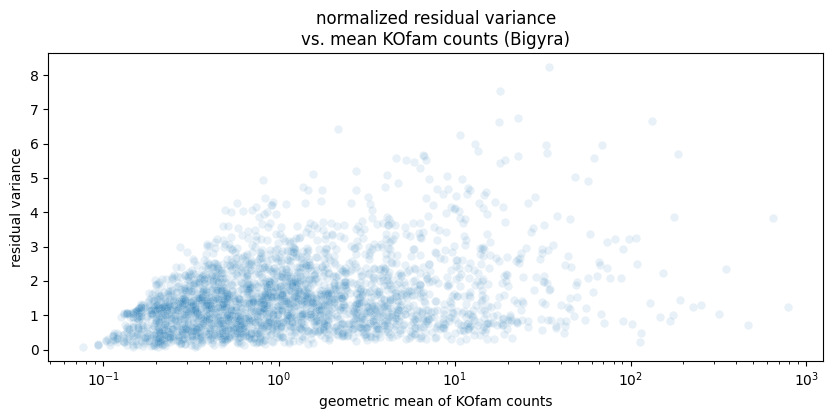

Normalizing slab 17 of 105: Bolidophyceae (28 samples, 5264 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 5264

R[write to console]: Total overdispersed genes: 5264

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 5264 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  6 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 166 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  3.695614070404

R[write to console]: Second step: Get residuals using fitted parameters for 5264 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.055889 secs



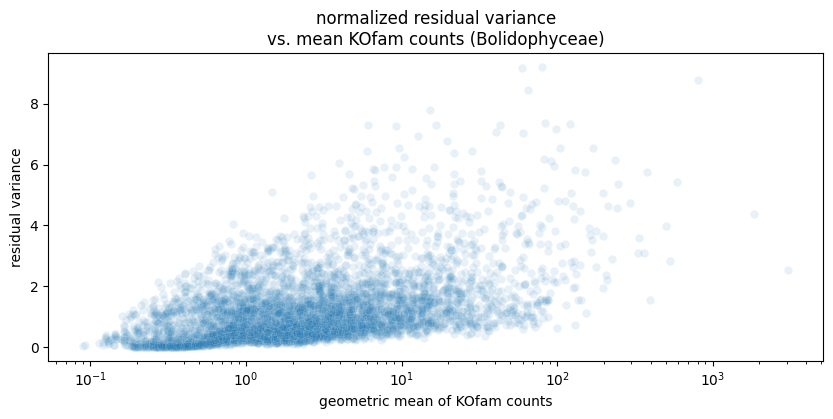

Normalizing slab 18 of 105: Brachiopoda (28 samples, 1684 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 1684

R[write to console]: Total overdispersed genes: 1683

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 1684 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 1683 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  3 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 82 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1.720853346969

R[write to console]: Second step: Get residuals using fitted parameters for 1684 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.70392 secs



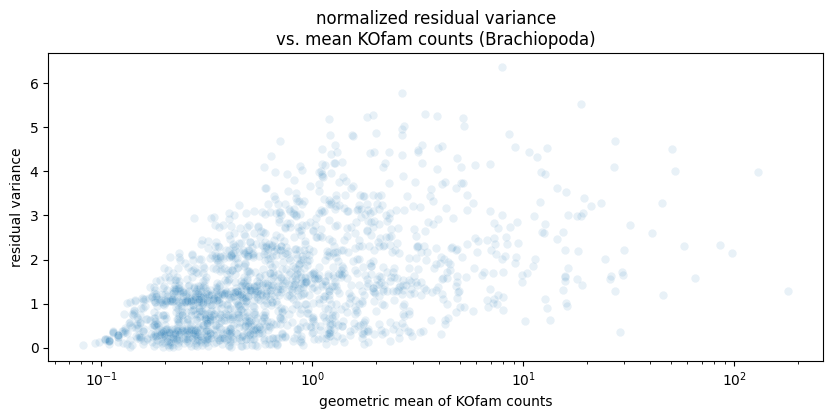

Normalizing slab 19 of 105: Bryozoa (28 samples, 529 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 529

R[write to console]: Total overdispersed genes: 529

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 529 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 529 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 29 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 529 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.785933 secs



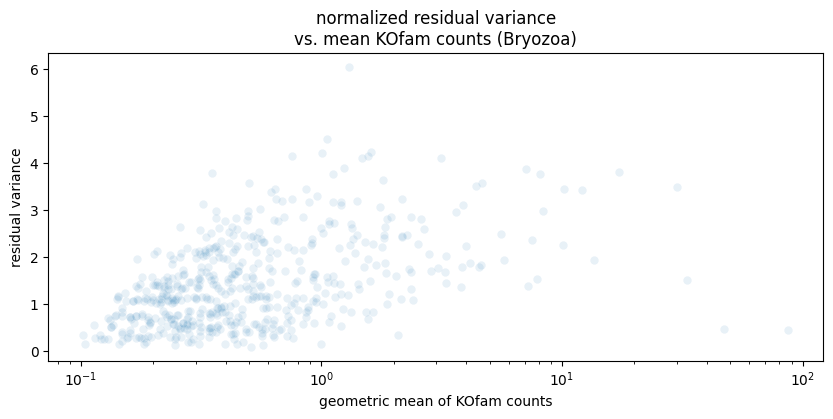

Skipping slab 20 of 105: Caldisericota (8 samples, 1 genes)
	Limited nonzero data in this slab undermines the reliability of normalization with sctransform.
Normalizing slab 21 of 105: Calditrichota (25 samples, 167 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 167

R[write to console]: Total overdispersed genes: 165

R[write to console]: Excluding 2 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 167 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 165 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  4 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 3 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.369949815225

R[write to console]: Second step: Get residuals using fitted parameters for 167 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.462497 secs



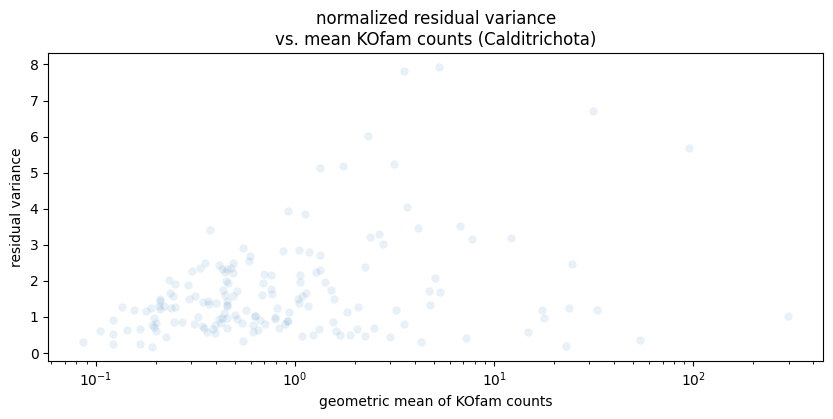

Normalizing slab 22 of 105: Campylobacterota (25 samples, 264 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 264

R[write to console]: Total overdispersed genes: 260

R[write to console]: Excluding 4 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 264 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 260 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  3 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 12 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.177189641721

R[write to console]: Second step: Get residuals using fitted parameters for 264 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.550257 secs



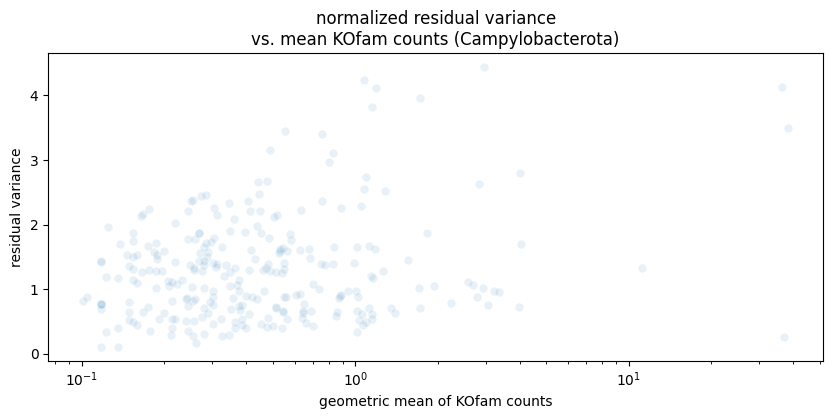

Skipping slab 23 of 105: candidate-division-WWE3 (25 samples, 7 genes)
	Limited nonzero data in this slab undermines the reliability of normalization with sctransform.
Normalizing slab 24 of 105: Candidatus-Aminicenantota (25 samples, 45 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 45

R[write to console]: Total overdispersed genes: 45

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 45 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 45 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 1 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 45 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.3725851 secs



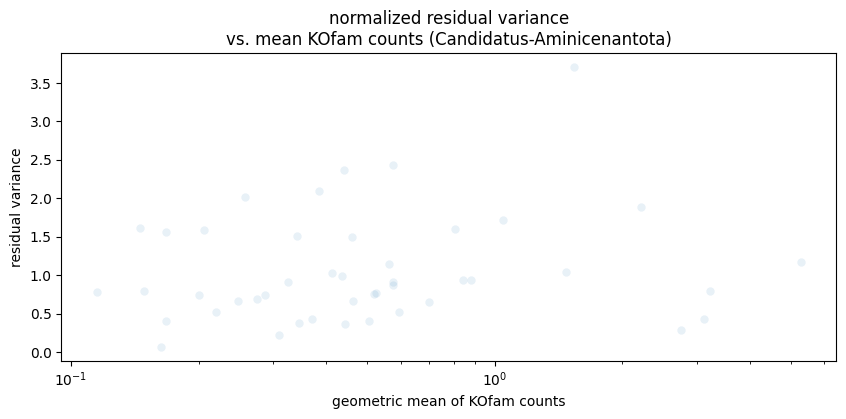

Normalizing slab 25 of 105: Candidatus-Babeliae (25 samples, 21 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 21

R[write to console]: Total overdispersed genes: 21

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 21 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 21 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 1 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 21 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.345803 secs



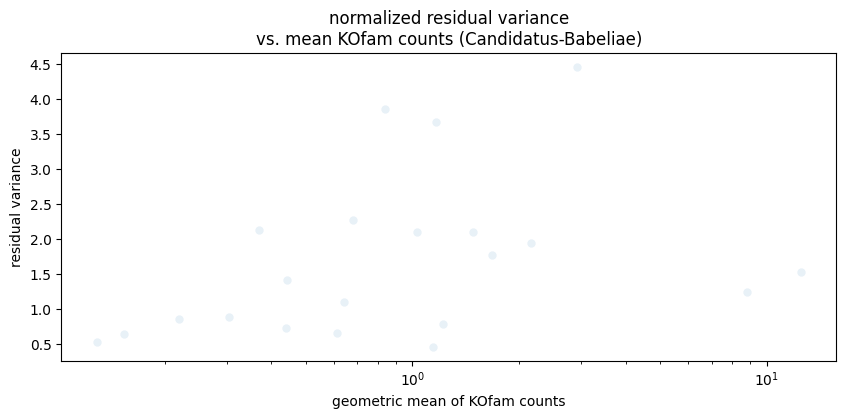

Normalizing slab 26 of 105: Candidatus-Calescamantes (25 samples, 23 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 23

R[write to console]: Total overdispersed genes: 23

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 23 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 23 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 2 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.327728770576

R[write to console]: Second step: Get residuals using fitted parameters for 23 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.35587 secs



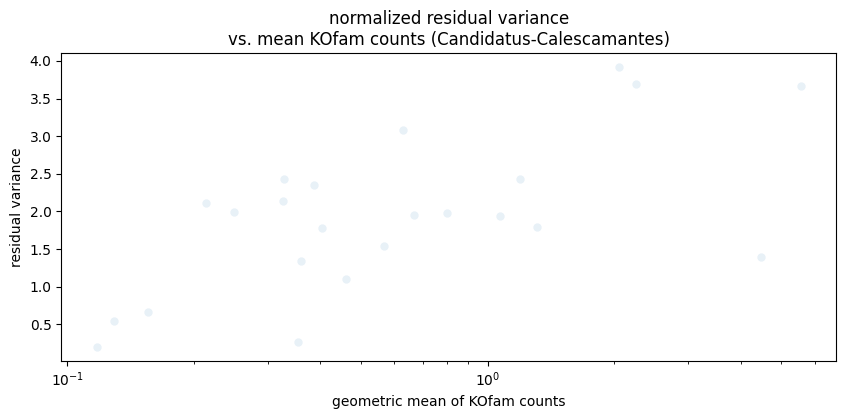

Normalizing slab 27 of 105: Candidatus-Cloacimonadota (25 samples, 99 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 99

R[write to console]: Total overdispersed genes: 98

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 99 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 98 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 5 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1.072945860561

R[write to console]: Second step: Get residuals using fitted parameters for 99 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.3999119 secs



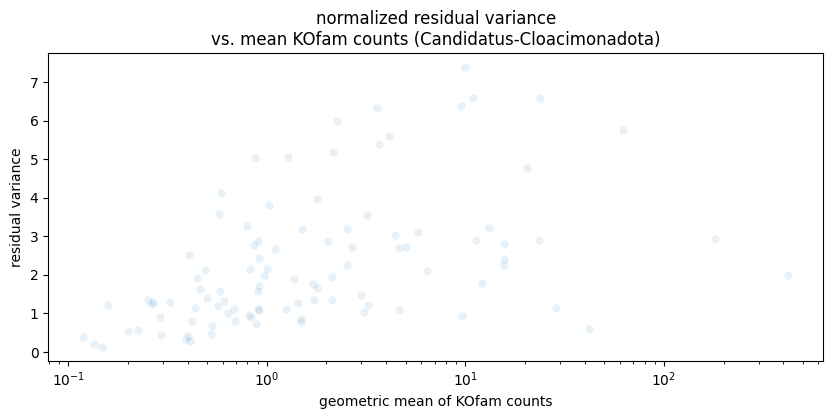

Normalizing slab 28 of 105: Candidatus-Hydrogenedentota (25 samples, 19 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 19

R[write to console]: Total overdispersed genes: 19

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 19 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 19 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.16

R[write to console]: Second step: Get residuals using fitted parameters for 19 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.3497679 secs



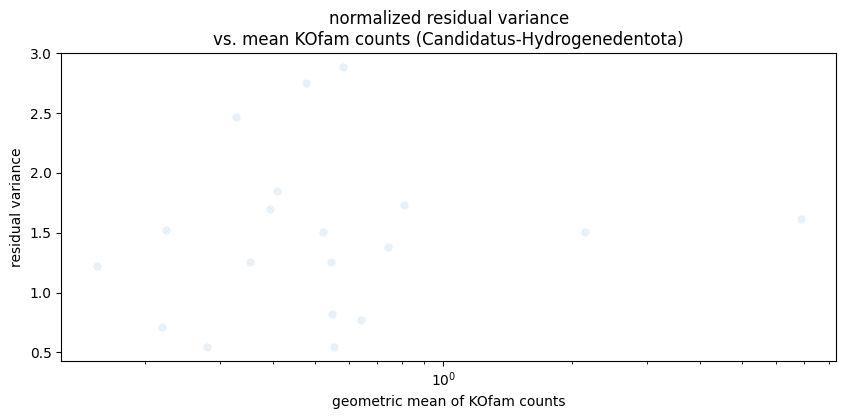

Normalizing slab 29 of 105: Candidatus-Latescibacterota (25 samples, 11 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 11

R[write to console]: Total overdispersed genes: 11

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 11 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 11 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 1 outliers - those will be ignored in fitting/regularization step


R[write to console]: Setting min_variance based on median UMI:  0.16

R[write to console]: Second step: Get residuals using fitted parameters for 11 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.3408449 secs



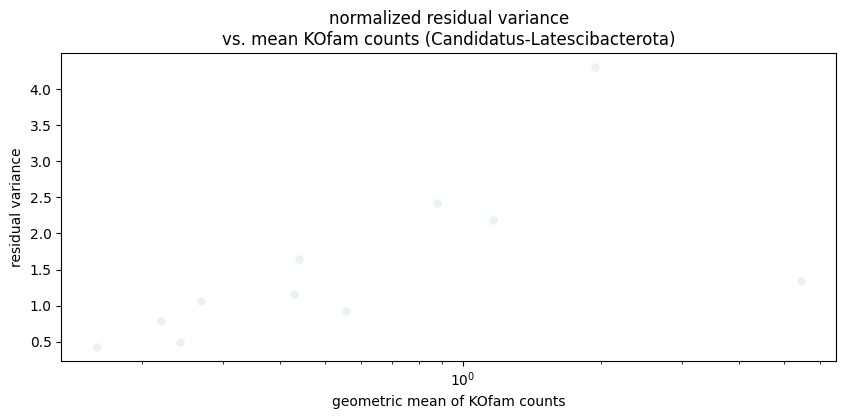

Normalizing slab 30 of 105: Candidatus-Microgenomates (25 samples, 34 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 34

R[write to console]: Total overdispersed genes: 34

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 34 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 34 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 34 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.3550229 secs



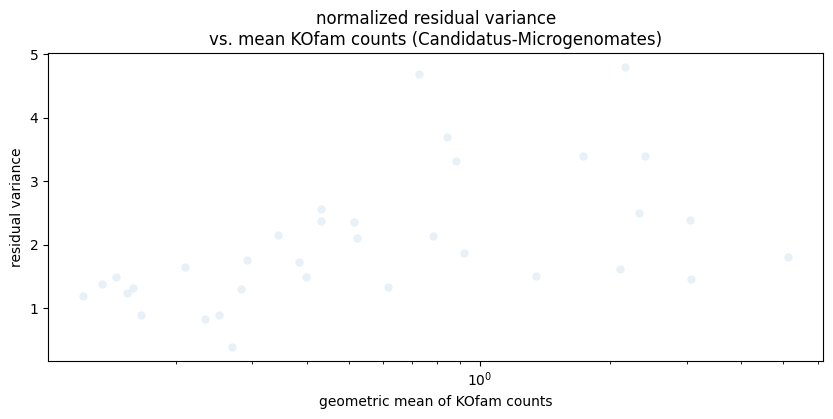

Normalizing slab 31 of 105: Candidatus-Moduliflexota (25 samples, 119 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 119

R[write to console]: Total overdispersed genes: 117

R[write to console]: Excluding 2 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 119 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 117 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 11 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 119 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.4153199 secs



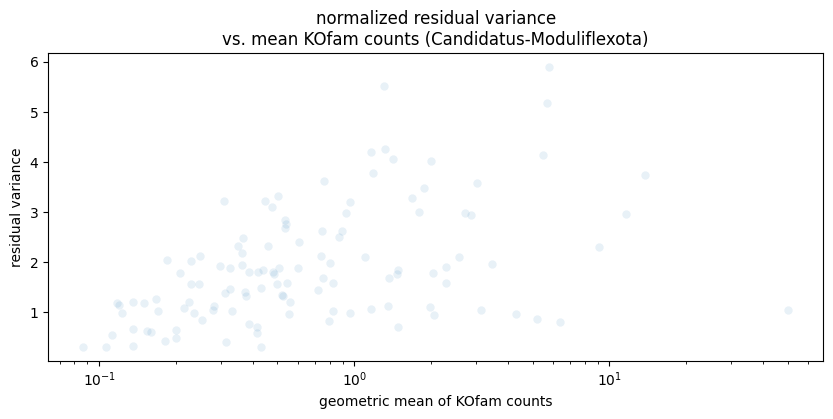

Normalizing slab 32 of 105: Candidatus-Neomarinimicrobiota (25 samples, 3226 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 3226

R[write to console]: Total overdispersed genes: 3213

R[write to console]: Excluding 13 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 3226 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  8 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 70 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1.760947578049

R[write to console]: Second step: Get residuals using fitted parameters for 3226 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.776231 secs



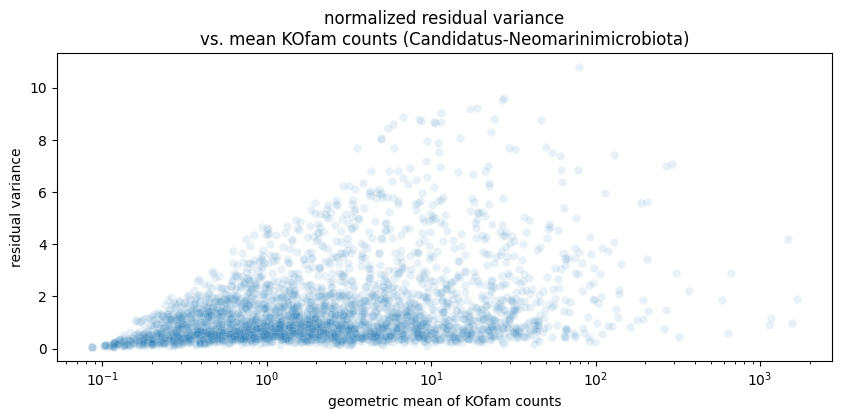

Normalizing slab 33 of 105: Candidatus-Omnitrophota (25 samples, 38 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 38

R[write to console]: Total overdispersed genes: 38

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 38 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 38 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 1 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.872681062276

R[write to console]: Second step: Get residuals using fitted parameters for 38 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.3820419 secs



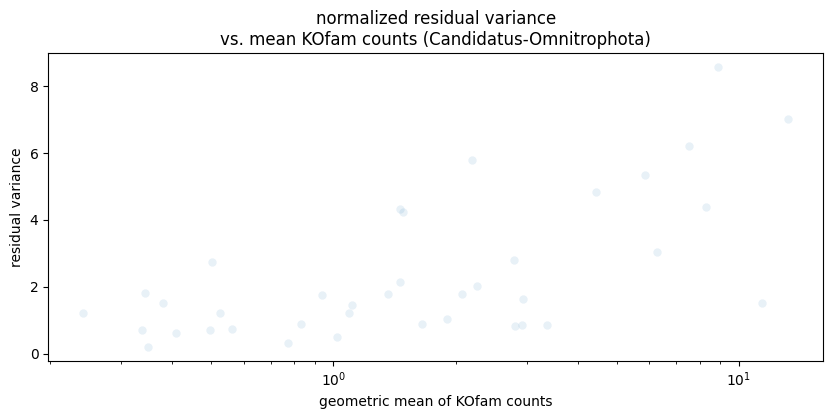

Skipping slab 34 of 105: Candidatus-Parcubacteria (25 samples, 6 genes)
	Limited nonzero data in this slab undermines the reliability of normalization with sctransform.
Normalizing slab 35 of 105: Candidatus-Poribacteria (25 samples, 109 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 109

R[write to console]: Total overdispersed genes: 109

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 109 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 109 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 6 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 109 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.425175 secs



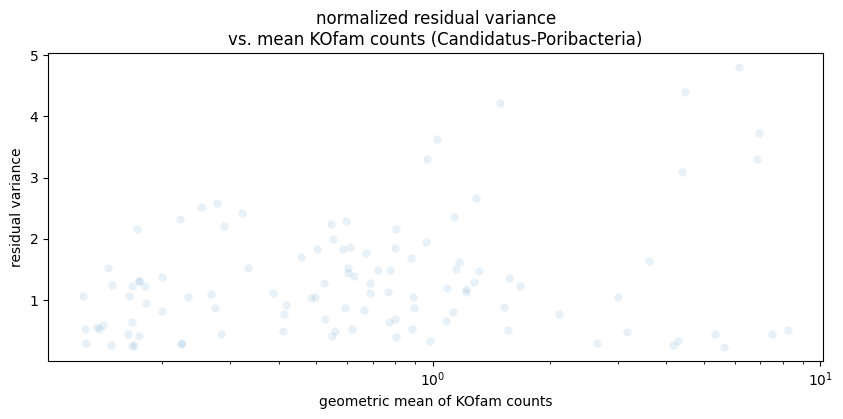

Skipping slab 36 of 105: Candidatus-Saccharibacteria (17 samples, 4 genes)
	Limited nonzero data in this slab undermines the reliability of normalization with sctransform.
Normalizing slab 37 of 105: Candidatus-Zixiibacteriota (25 samples, 46 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 46

R[write to console]: Total overdispersed genes: 46

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 46 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 46 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 1 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 46 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.3760641 secs



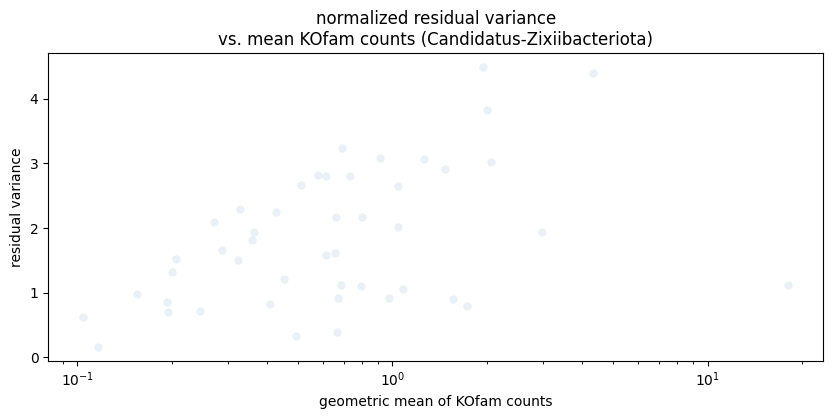

Normalizing slab 38 of 105: Cercozoa (28 samples, 2549 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2549

R[write to console]: Total overdispersed genes: 2549

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2549 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  2 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 67 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1.44

R[write to console]: Second step: Get residuals using fitted parameters for 2549 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.879251 secs



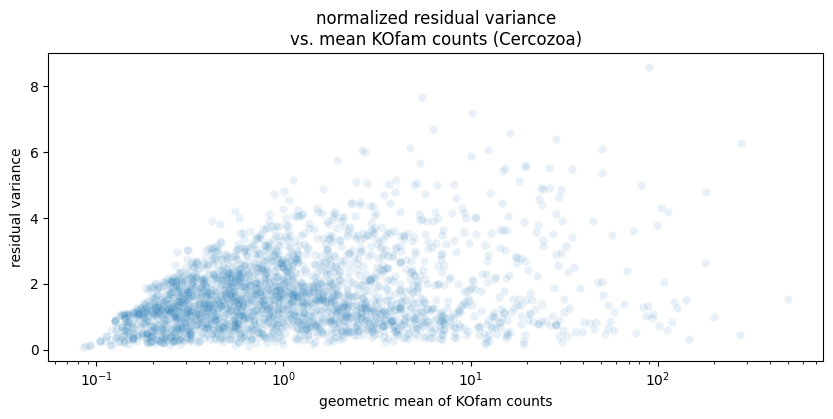

Normalizing slab 39 of 105: Chlamydiota (25 samples, 81 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 81

R[write to console]: Total overdispersed genes: 80

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 81 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 80 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  3 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 5 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 81 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.4014711 secs



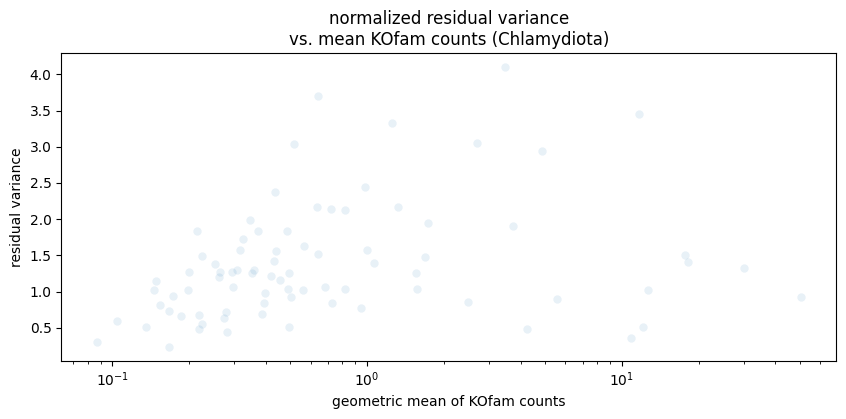

Normalizing slab 40 of 105: Chlorobiota (25 samples, 201 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 201

R[write to console]: Total overdispersed genes: 198

R[write to console]: Excluding 3 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 201 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 198 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  3 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 7 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.165509021584

R[write to console]: Second step: Get residuals using fitted parameters for 201 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.4948161 secs



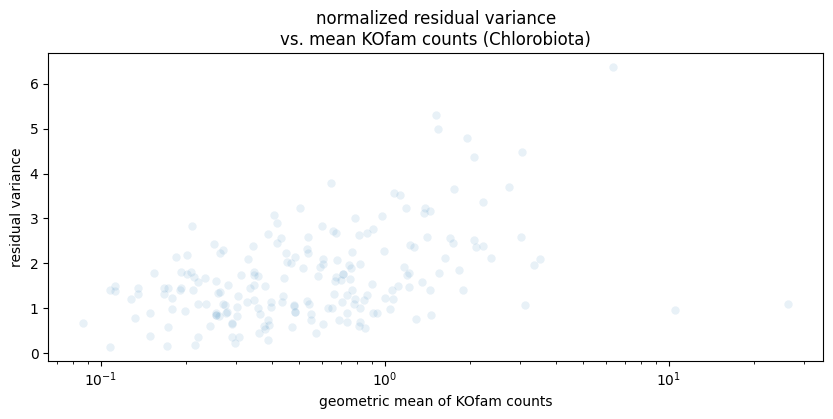

Normalizing slab 41 of 105: Chloroflexota (25 samples, 1963 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 1963

R[write to console]: Total overdispersed genes: 1954

R[write to console]: Excluding 9 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 1963 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 1954 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  63 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 55 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.509370544804

R[write to console]: Second step: Get residuals using fitted parameters for 1963 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.752051 secs



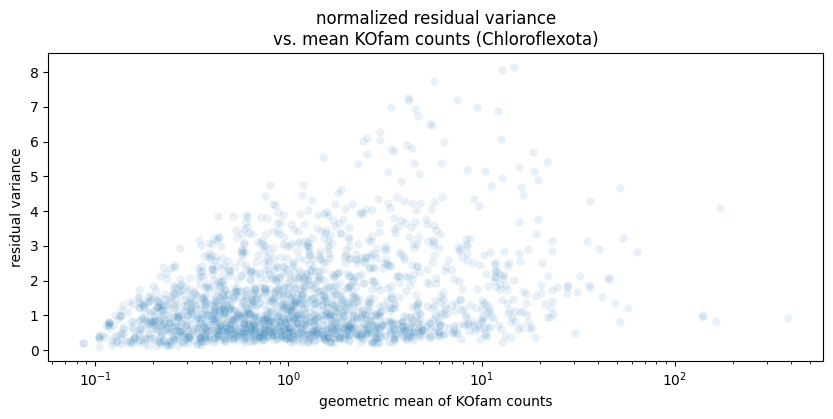

Normalizing slab 42 of 105: Chlorophyta (28 samples, 6719 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 6719

R[write to console]: Total overdispersed genes: 6716

R[write to console]: Excluding 3 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 6719 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 74 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  29.16

R[write to console]: Second step: Get residuals using fitted parameters for 6719 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.237895 secs



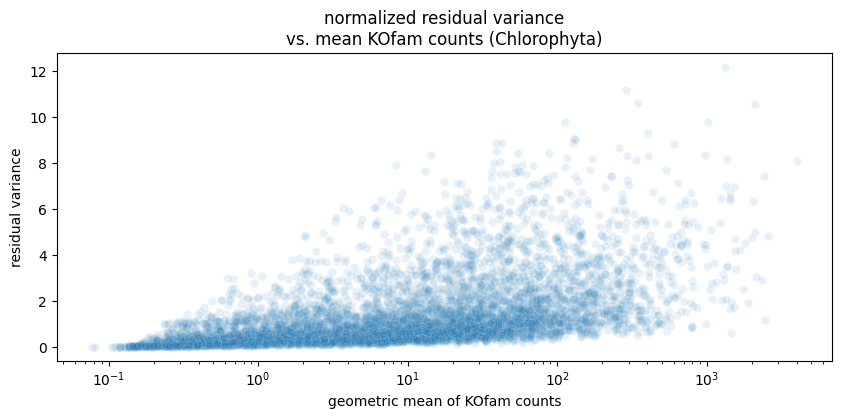

Normalizing slab 43 of 105: Chordata (28 samples, 7412 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 7412

R[write to console]: Total overdispersed genes: 7412

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 7412 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 42 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  40.506783876036

R[write to console]: Second step: Get residuals using fitted parameters for 7412 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.210706 secs



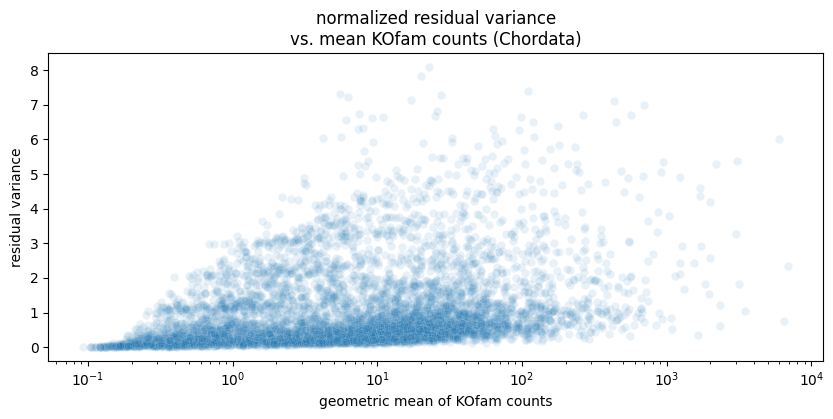

Normalizing slab 44 of 105: Chrysiogenota (25 samples, 14 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 14

R[write to console]: Total overdispersed genes: 14

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 14 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 14 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.16

R[write to console]: Second step: Get residuals using fitted parameters for 14 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.36713 secs



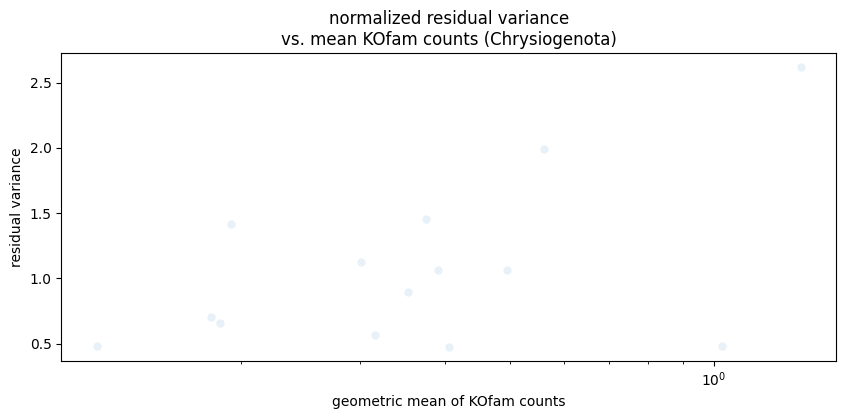

Normalizing slab 45 of 105: Chrysophyceae (28 samples, 4675 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 4675

R[write to console]: Total overdispersed genes: 4675

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 4675 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 32 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  6.76

R[write to console]: Second step: Get residuals using fitted parameters for 4675 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.07894 secs



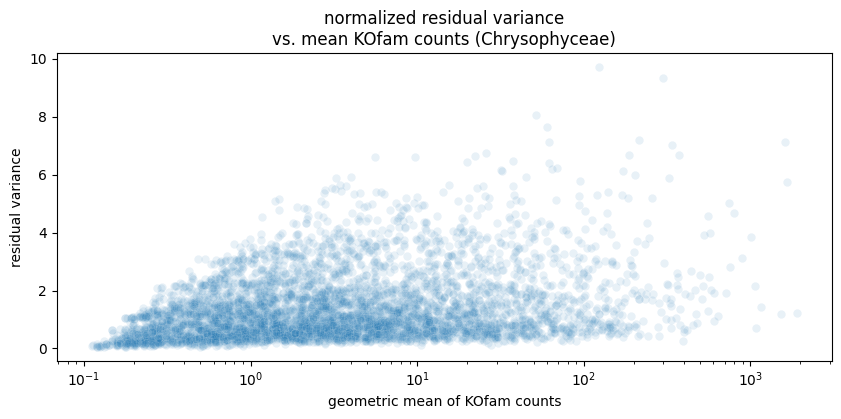

Normalizing slab 46 of 105: Ciliophora (28 samples, 3704 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 3704

R[write to console]: Total overdispersed genes: 3703

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 3704 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 26 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  36.612156436804

R[write to console]: Second step: Get residuals using fitted parameters for 3704 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.087581 secs



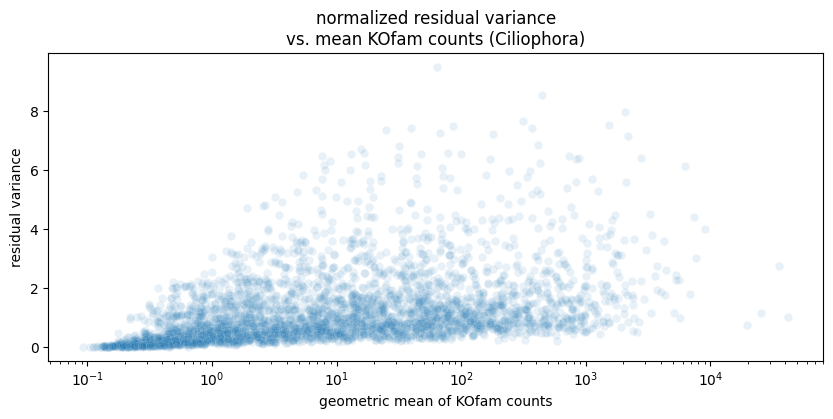

Normalizing slab 47 of 105: Cnidaria (28 samples, 6729 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 6729

R[write to console]: Total overdispersed genes: 6729

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 6729 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 40 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  7.84

R[write to console]: Second step: Get residuals using fitted parameters for 6729 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.250144 secs



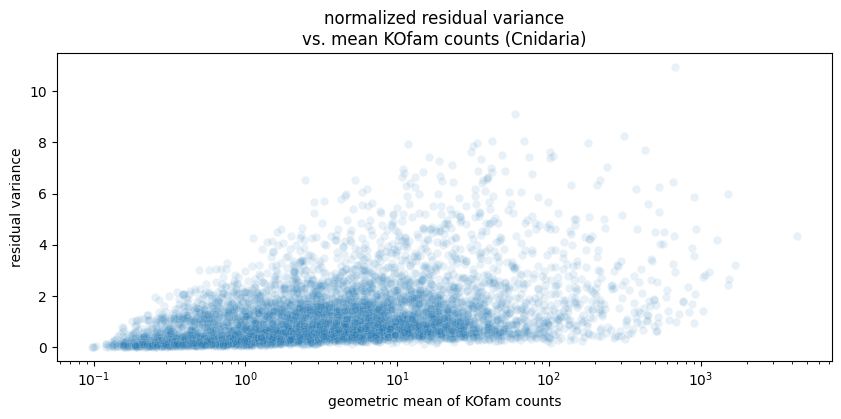

Skipping slab 48 of 105: Coprothermobacterota (18 samples, 3 genes)
	Limited nonzero data in this slab undermines the reliability of normalization with sctransform.
Normalizing slab 49 of 105: Cryptophyceae (28 samples, 2554 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2554

R[write to console]: Total overdispersed genes: 2552

R[write to console]: Excluding 2 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2554 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  3 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 83 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1.44

R[write to console]: Second step: Get residuals using fitted parameters for 2554 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.863098 secs



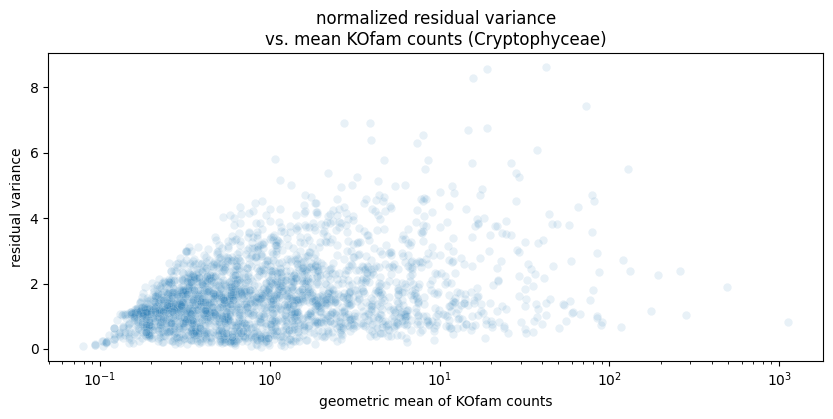

Normalizing slab 50 of 105: Cyanobacteriota (25 samples, 1804 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 1804

R[write to console]: Total overdispersed genes: 1797

R[write to console]: Excluding 7 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 1804 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 1797 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  33 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 335 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 1804 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.679074 secs



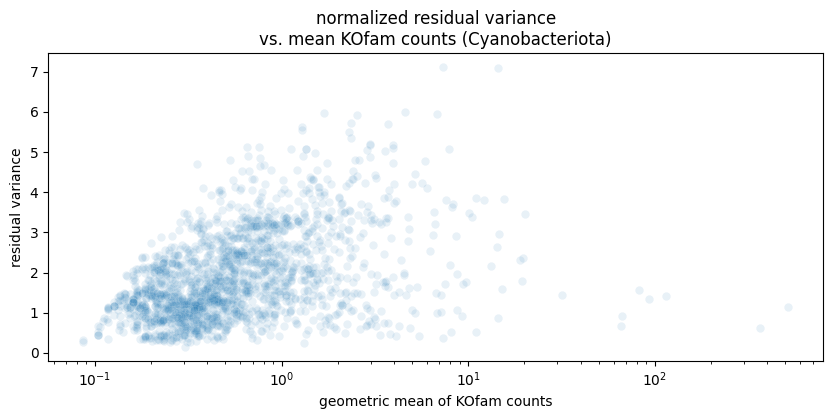

Normalizing slab 51 of 105: Deferribacterota (25 samples, 65 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 65

R[write to console]: Total overdispersed genes: 65

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 65 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 65 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 8 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 65 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.3960249 secs



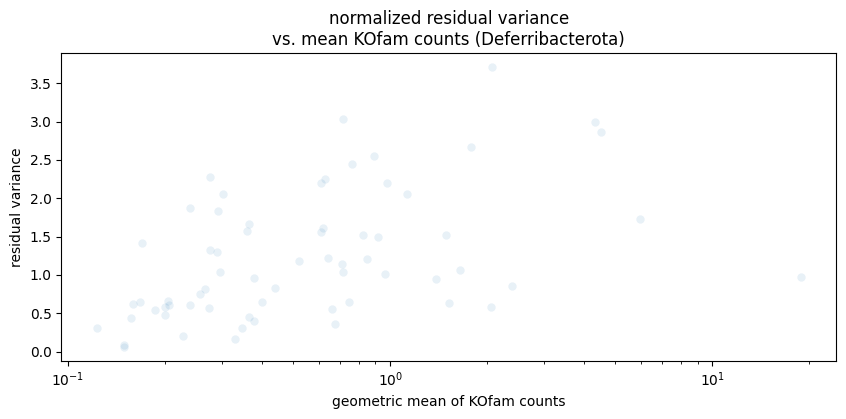

Normalizing slab 52 of 105: Deinococcota (25 samples, 165 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 165

R[write to console]: Total overdispersed genes: 165

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 165 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 165 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  2 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 8 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 165 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.4431038 secs



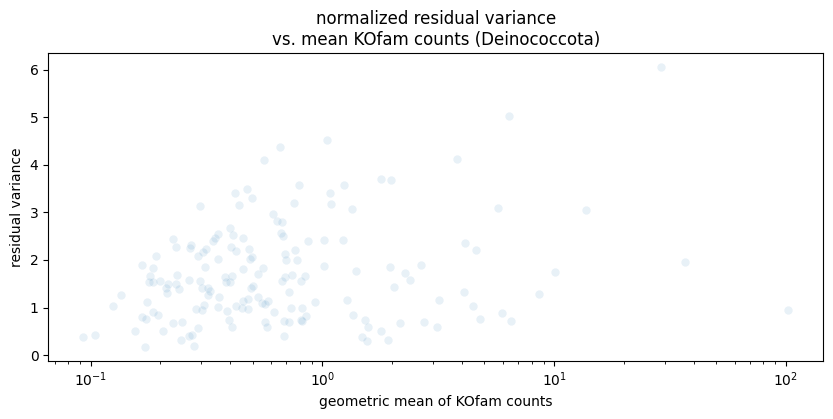

Normalizing slab 53 of 105: Dictyochophyceae (28 samples, 4571 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 4571

R[write to console]: Total overdispersed genes: 4569

R[write to console]: Excluding 2 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 4571 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 42 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  4.84

R[write to console]: Second step: Get residuals using fitted parameters for 4571 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.988698 secs



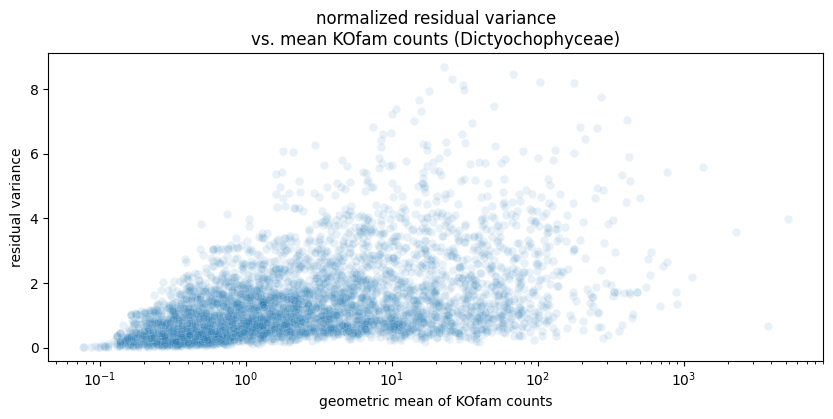

Normalizing slab 54 of 105: Dictyoglomota (25 samples, 22 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 22

R[write to console]: Total overdispersed genes: 22

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 22 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 22 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 1 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.16

R[write to console]: Second step: Get residuals using fitted parameters for 22 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.371207 secs



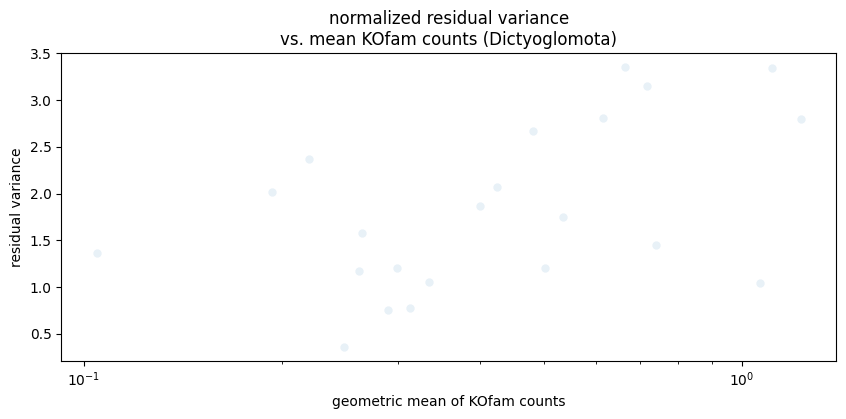

Normalizing slab 55 of 105: Dinoflagellata (28 samples, 10823 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 10823

R[write to console]: Total overdispersed genes: 10820

R[write to console]: Excluding 3 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 10823 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 24 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  130.730616195001

R[write to console]: Second step: Get residuals using fitted parameters for 10823 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.195069 secs



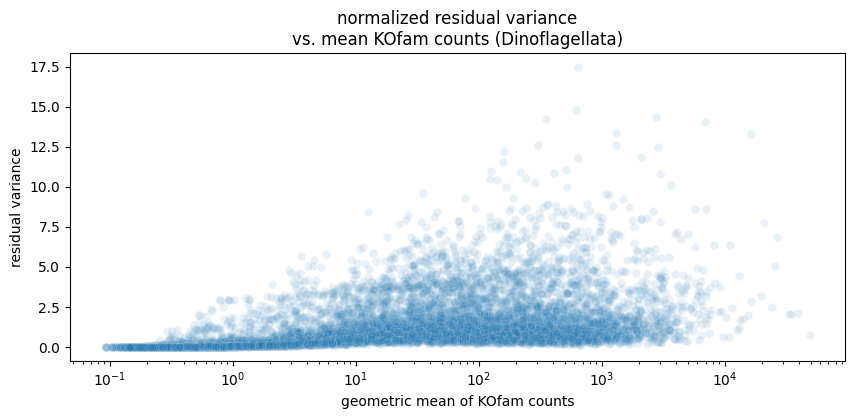

Normalizing slab 56 of 105: Discosea (28 samples, 2481 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2481

R[write to console]: Total overdispersed genes: 2481

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2481 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  24 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 47 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1.1217351744

R[write to console]: Second step: Get residuals using fitted parameters for 2481 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.790046 secs



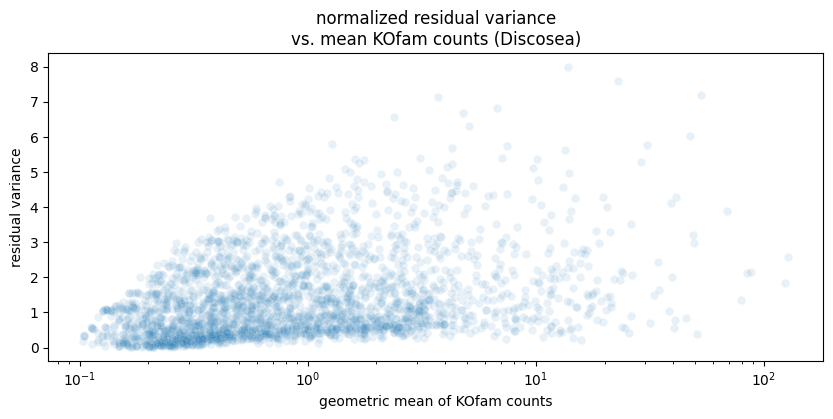

Normalizing slab 57 of 105: Echinodermata (28 samples, 2095 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2095

R[write to console]: Total overdispersed genes: 2095

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2095 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 66 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1.908716322969

R[write to console]: Second step: Get residuals using fitted parameters for 2095 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.906995 secs



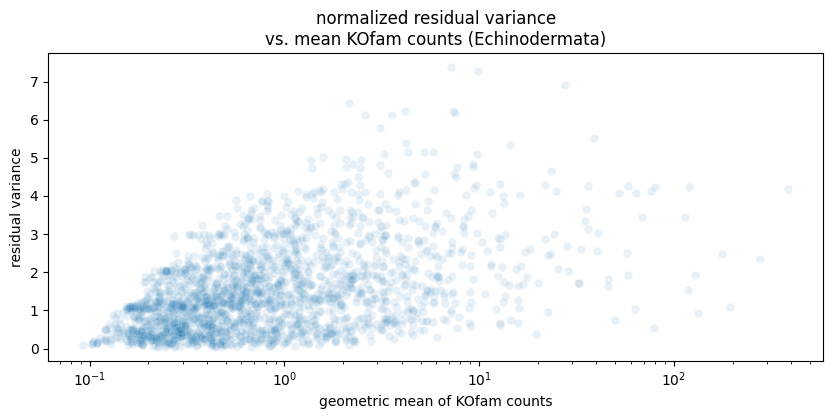

Normalizing slab 58 of 105: Elusimicrobiota (23 samples, 10 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 10

R[write to console]: Total overdispersed genes: 10

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 10 by 23

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 10 genes, 23 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.731632176025

R[write to console]: Second step: Get residuals using fitted parameters for 10 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.35973 secs



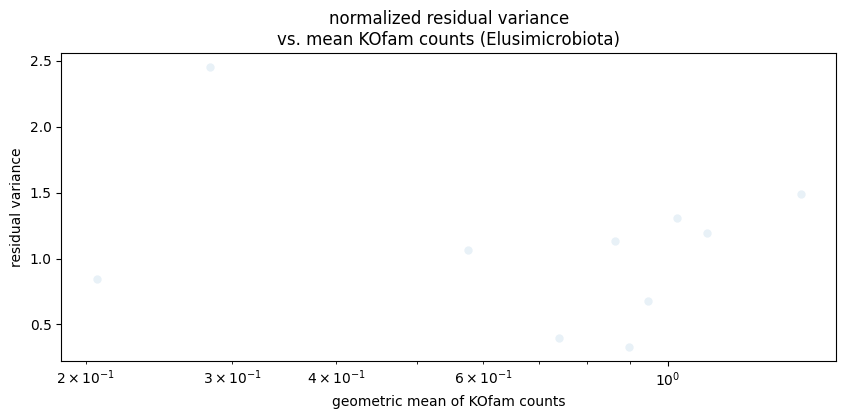

Normalizing slab 59 of 105: Euglenozoa (28 samples, 1098 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 1098

R[write to console]: Total overdispersed genes: 1098

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 1098 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 1098 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  2 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 37 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 1098 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.188921 secs



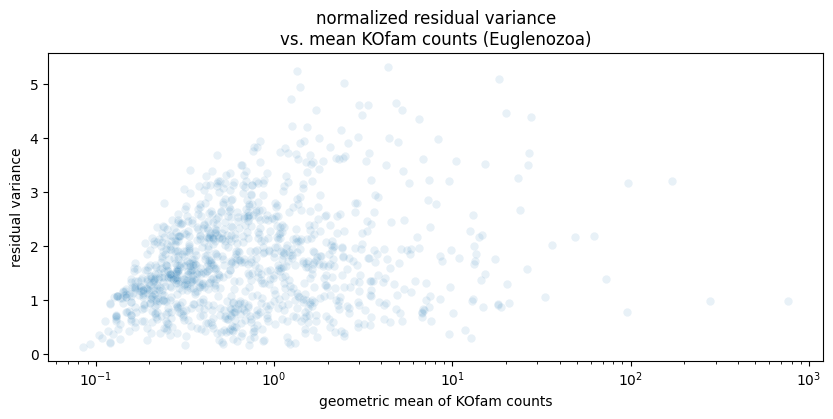

Normalizing slab 60 of 105: Eustigmatophyceae (28 samples, 835 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 835

R[write to console]: Total overdispersed genes: 834

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 835 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 834 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  2 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 100 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  2.128984482816

R[write to console]: Second step: Get residuals using fitted parameters for 835 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.96559 secs



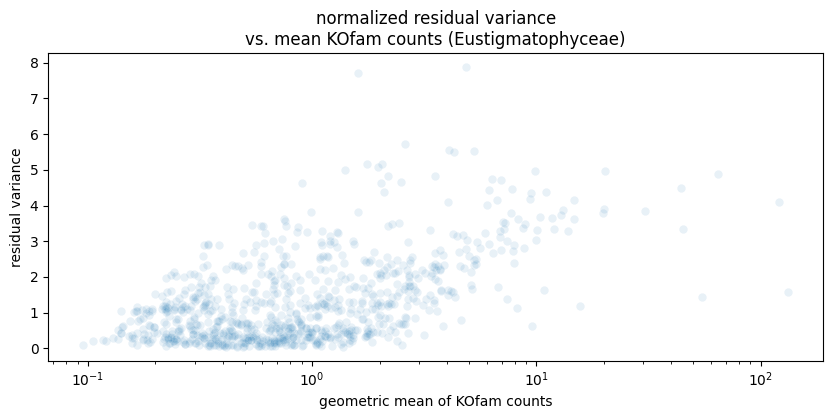

Normalizing slab 61 of 105: Evosea (28 samples, 530 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 530

R[write to console]: Total overdispersed genes: 528

R[write to console]: Excluding 2 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 530 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 528 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 16 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 530 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.7557049 secs



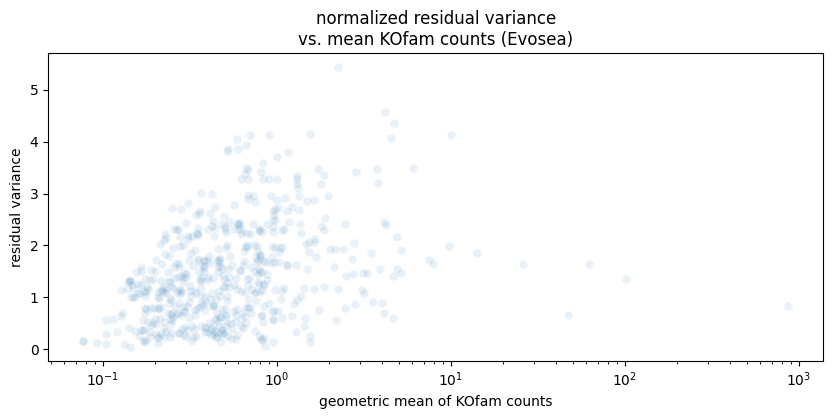

Normalizing slab 62 of 105: Fibrobacterota (25 samples, 222 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 222

R[write to console]: Total overdispersed genes: 222

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 222 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 222 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  9 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 12 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.430658812516

R[write to console]: Second step: Get residuals using fitted parameters for 222 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.4887741 secs



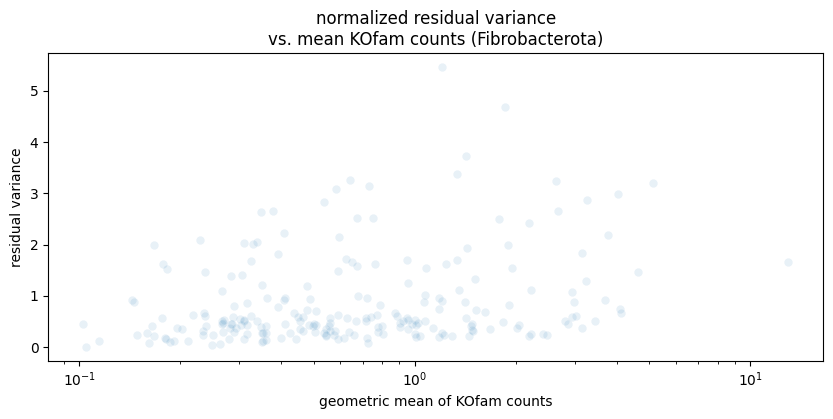

Normalizing slab 63 of 105: Foraminifera (28 samples, 2795 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2795

R[write to console]: Total overdispersed genes: 2793

R[write to console]: Excluding 2 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2795 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 87 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 2795 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.808183 secs



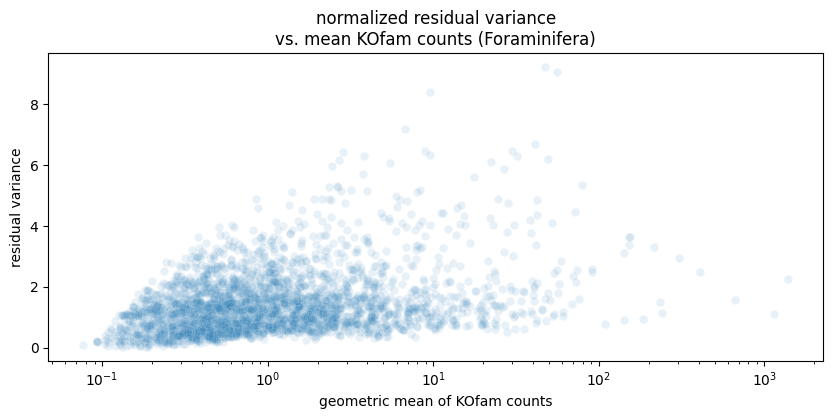

Normalizing slab 64 of 105: Fornicata (28 samples, 13 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 13

R[write to console]: Total overdispersed genes: 13

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 13 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 13 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 13 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.365207 secs



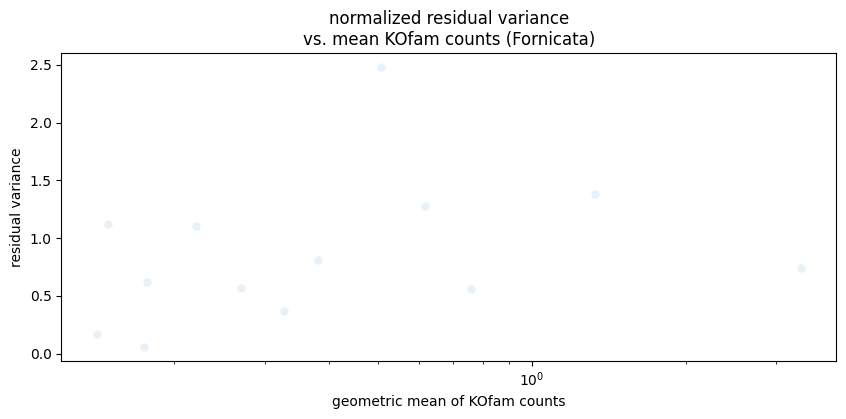

Normalizing slab 65 of 105: Fusobacteriota (25 samples, 72 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 72

R[write to console]: Total overdispersed genes: 72

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 72 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 72 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 6 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1.058664019396

R[write to console]: Second step: Get residuals using fitted parameters for 72 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.3908579 secs



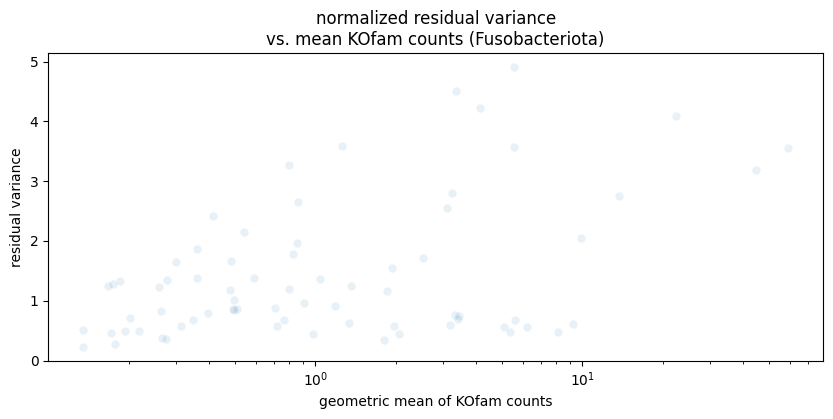

Normalizing slab 66 of 105: Gastrotricha (28 samples, 619 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 619

R[write to console]: Total overdispersed genes: 619

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 619 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 619 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 11 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1.44

R[write to console]: Second step: Get residuals using fitted parameters for 619 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.796284 secs



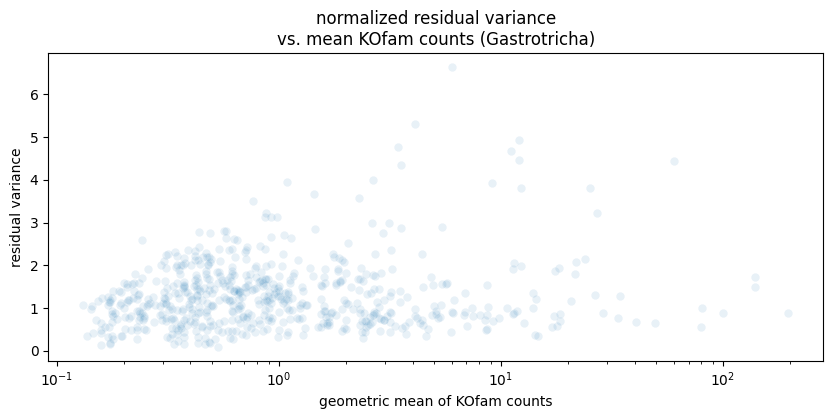

Normalizing slab 67 of 105: Gemmatimonadota (25 samples, 110 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 110

R[write to console]: Total overdispersed genes: 110

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 110 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 110 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  2 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 7 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.16

R[write to console]: Second step: Get residuals using fitted parameters for 110 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.4174049 secs



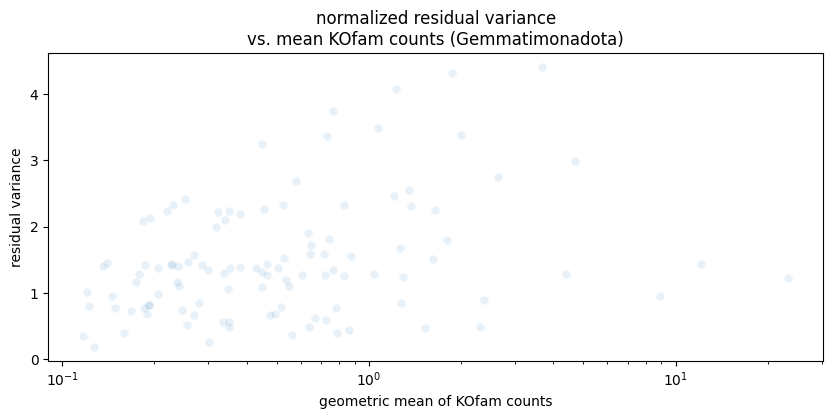

Normalizing slab 68 of 105: Glaucocystophyceae (28 samples, 857 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 857

R[write to console]: Total overdispersed genes: 856

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 857 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 856 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 31 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 857 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.982954 secs



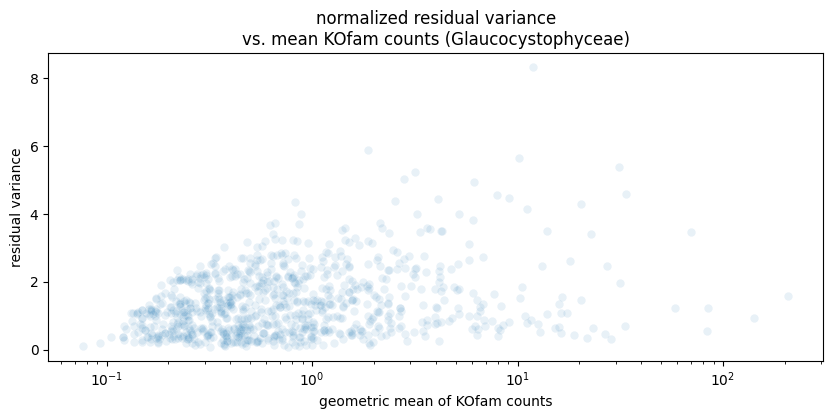

Normalizing slab 69 of 105: Haptophyta (28 samples, 7701 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 7701

R[write to console]: Total overdispersed genes: 7699

R[write to console]: Excluding 2 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 7701 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 39 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  14.679074243584

R[write to console]: Second step: Get residuals using fitted parameters for 7701 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.566266 secs



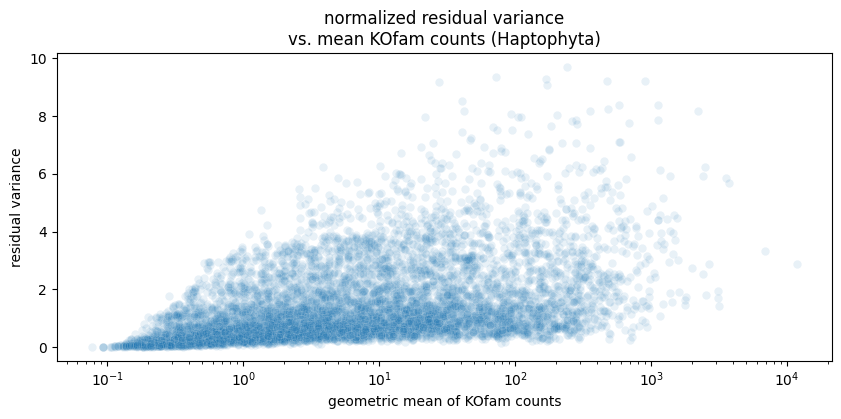

Normalizing slab 70 of 105: Heterolobosea (28 samples, 341 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 341

R[write to console]: Total overdispersed genes: 340

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 341 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 340 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 14 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.733218863524

R[write to console]: Second step: Get residuals using fitted parameters for 341 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5910292 secs



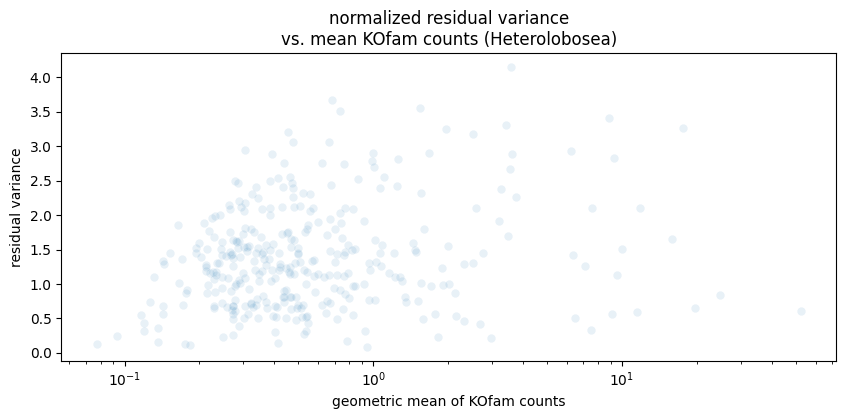

Normalizing slab 71 of 105: Ignavibacteriota (25 samples, 139 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 139

R[write to console]: Total overdispersed genes: 139

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 139 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 139 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 3 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 139 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.4362931 secs



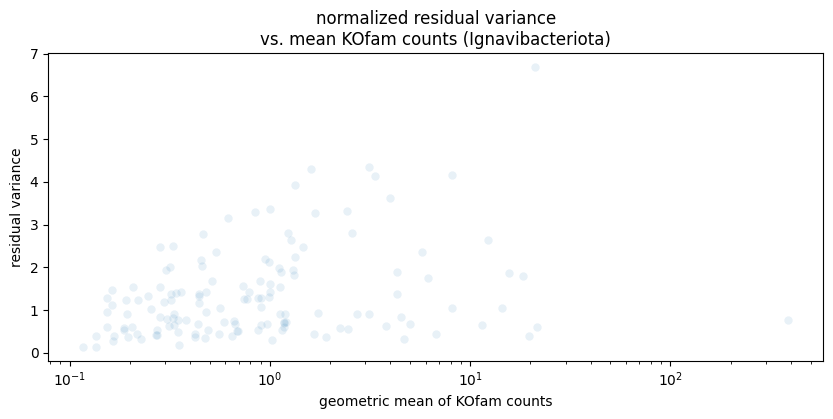

Normalizing slab 72 of 105: Lentisphaerota (25 samples, 159 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 159

R[write to console]: Total overdispersed genes: 159

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 159 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 159 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  2 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 10 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 159 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.4489479 secs



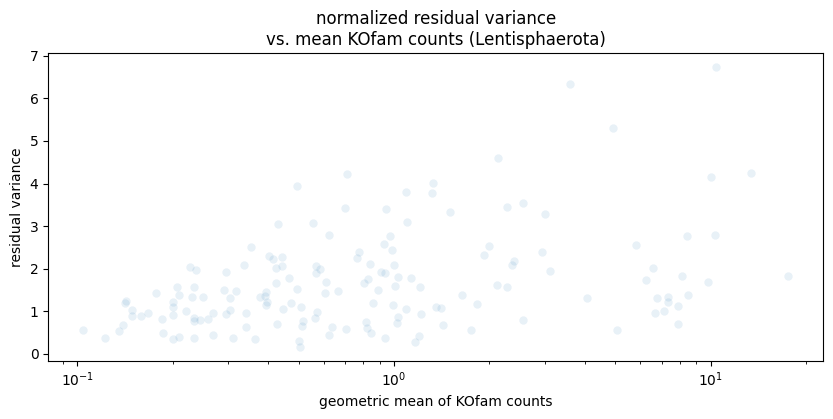

Normalizing slab 73 of 105: MAST-3-4 (28 samples, 3813 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 3813

R[write to console]: Total overdispersed genes: 3812

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 3813 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 52 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  4.84

R[write to console]: Second step: Get residuals using fitted parameters for 3813 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.955031 secs



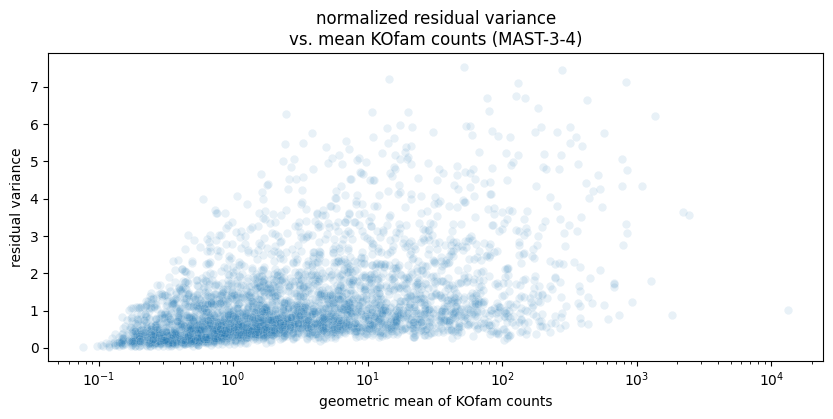

Normalizing slab 74 of 105: Mollusca (28 samples, 2927 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2927

R[write to console]: Total overdispersed genes: 2925

R[write to console]: Excluding 2 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2927 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  2 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 97 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1.96

R[write to console]: Second step: Get residuals using fitted parameters for 2927 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.977505 secs



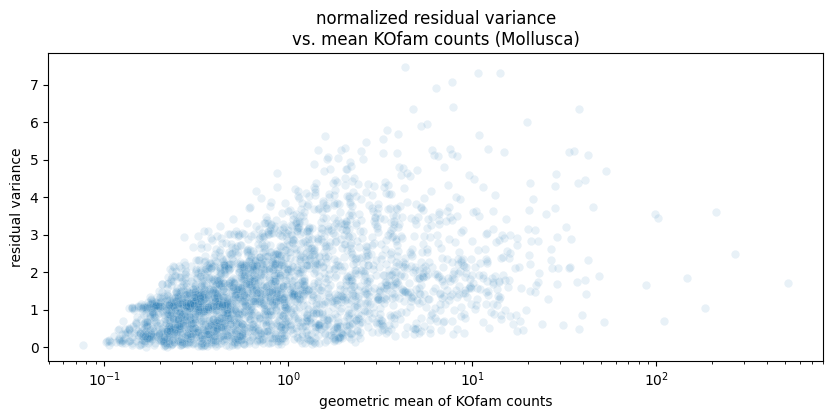

Normalizing slab 75 of 105: Mycoplasmatota (25 samples, 56 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 56

R[write to console]: Total overdispersed genes: 55

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 56 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 55 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 2 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.364049323225

R[write to console]: Second step: Get residuals using fitted parameters for 56 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.3822491 secs



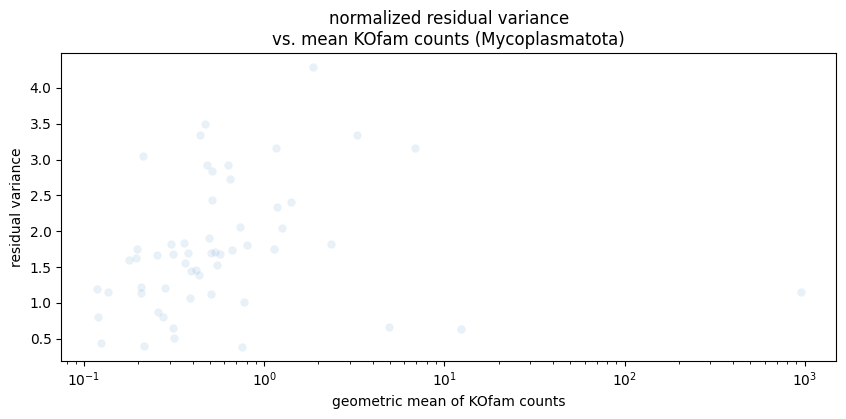

Normalizing slab 76 of 105: Myxococcota (25 samples, 747 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 747

R[write to console]: Total overdispersed genes: 744

R[write to console]: Excluding 3 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 747 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 744 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  5 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 48 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 747 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.8835318 secs



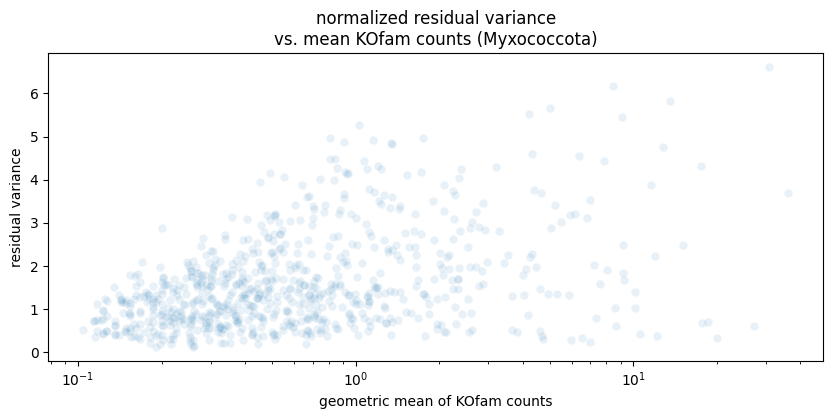

Normalizing slab 77 of 105: Nematoda (28 samples, 340 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 340

R[write to console]: Total overdispersed genes: 340

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 340 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 340 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 22 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 340 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.6235368 secs



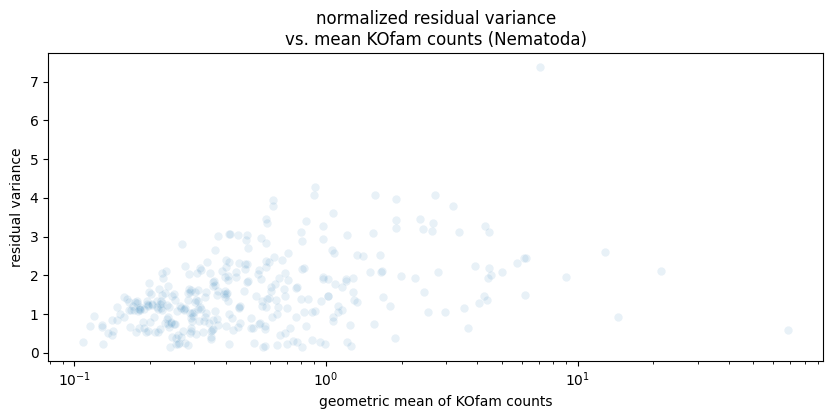

Normalizing slab 78 of 105: Nitrospinota (25 samples, 153 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 153

R[write to console]: Total overdispersed genes: 151

R[write to console]: Excluding 2 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 153 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 151 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  2 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 12 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 153 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.4489989 secs



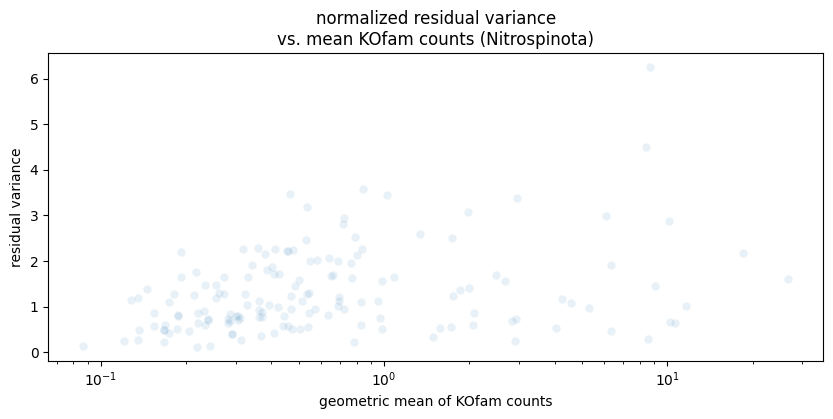

Normalizing slab 79 of 105: Nitrospirota (25 samples, 82 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 82

R[write to console]: Total overdispersed genes: 79

R[write to console]: Excluding 3 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 82 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 79 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 9 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.16

R[write to console]: Second step: Get residuals using fitted parameters for 82 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.3943701 secs



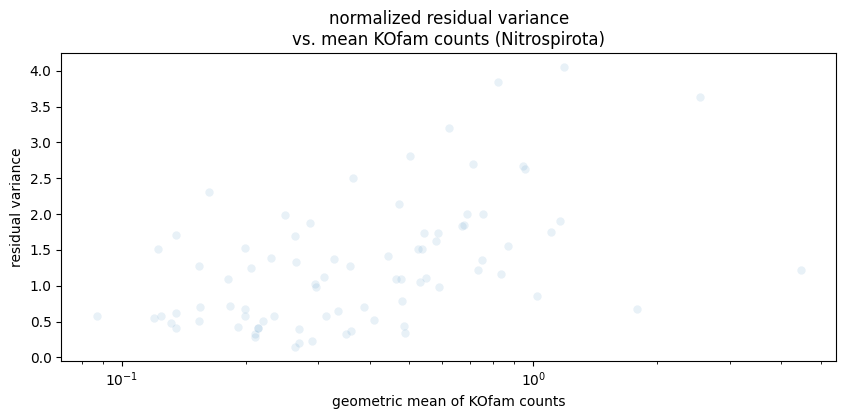

Normalizing slab 80 of 105: Oomycota (28 samples, 1137 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 1137

R[write to console]: Total overdispersed genes: 1136

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 1137 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 1136 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  5 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 78 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1.439916001225

R[write to console]: Second step: Get residuals using fitted parameters for 1137 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.180943 secs



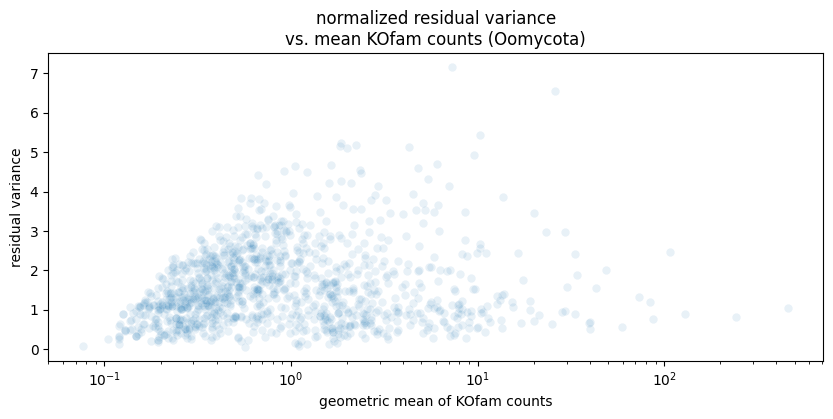

Normalizing slab 81 of 105: Parabasalia (28 samples, 60 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 60

R[write to console]: Total overdispersed genes: 60

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 60 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 60 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 1 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.743588883856

R[write to console]: Second step: Get residuals using fitted parameters for 60 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.391516 secs



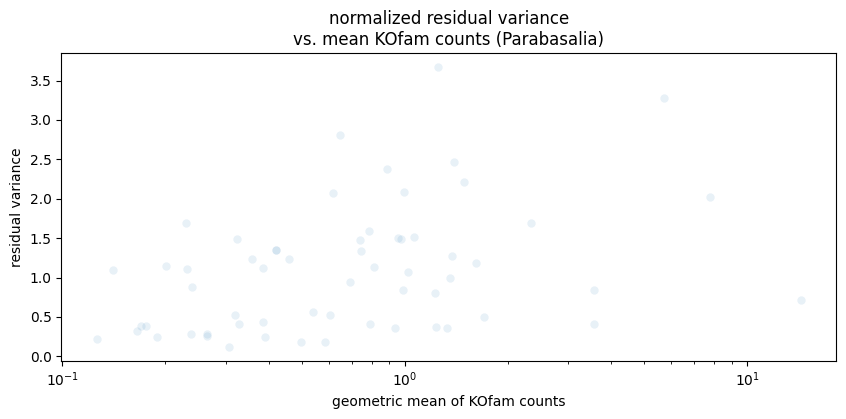

Normalizing slab 82 of 105: Pelagophyceae (28 samples, 6164 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 6164

R[write to console]: Total overdispersed genes: 6163

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 6164 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 48 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  23.019230282896

R[write to console]: Second step: Get residuals using fitted parameters for 6164 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.179847 secs



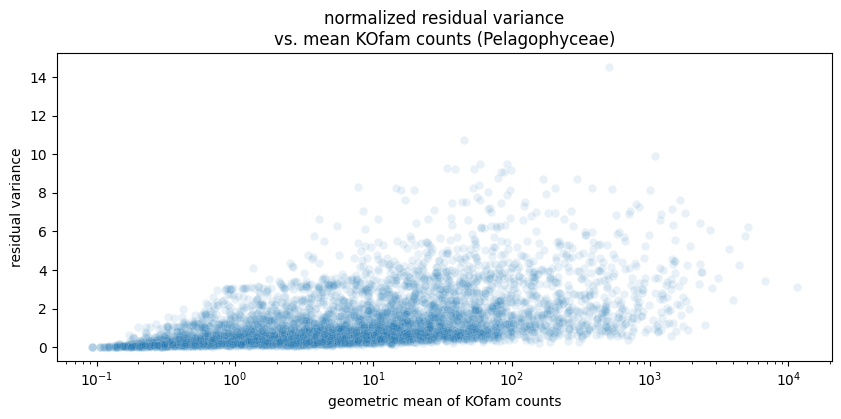

Normalizing slab 83 of 105: Perkinsozoa (28 samples, 191 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 191

R[write to console]: Total overdispersed genes: 191

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 191 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 191 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 6 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 191 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.4841599 secs



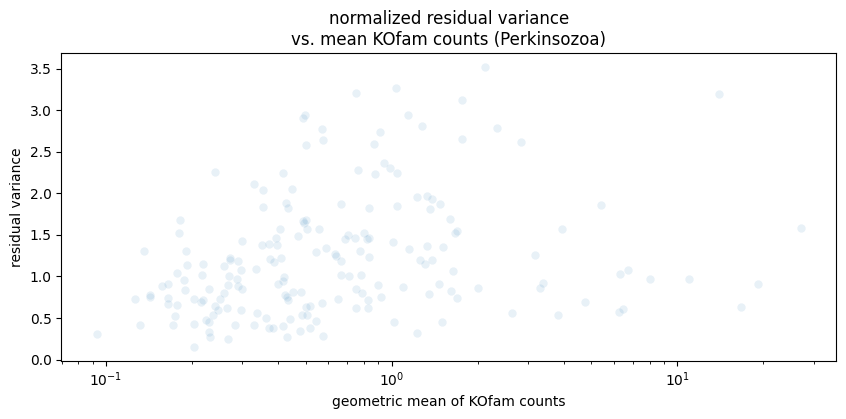

Normalizing slab 84 of 105: Phaeophyceae (28 samples, 574 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 574

R[write to console]: Total overdispersed genes: 574

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 574 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 574 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 28 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.988403814225

R[write to console]: Second step: Get residuals using fitted parameters for 574 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.790272 secs



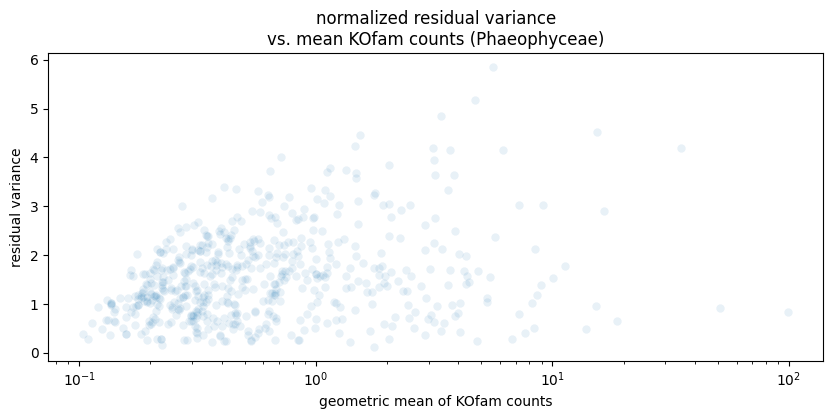

Normalizing slab 85 of 105: Pinguiophyceae (28 samples, 465 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 465

R[write to console]: Total overdispersed genes: 465

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 465 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 465 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 28 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 465 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.6806099 secs



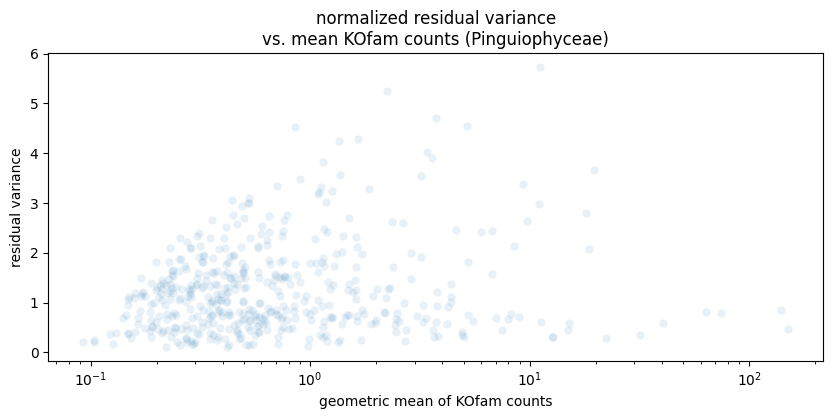

Normalizing slab 86 of 105: Planctomycetota (25 samples, 1252 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 1252

R[write to console]: Total overdispersed genes: 1233

R[write to console]: Excluding 19 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 1252 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 1233 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  18 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 45 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 1252 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.259251 secs



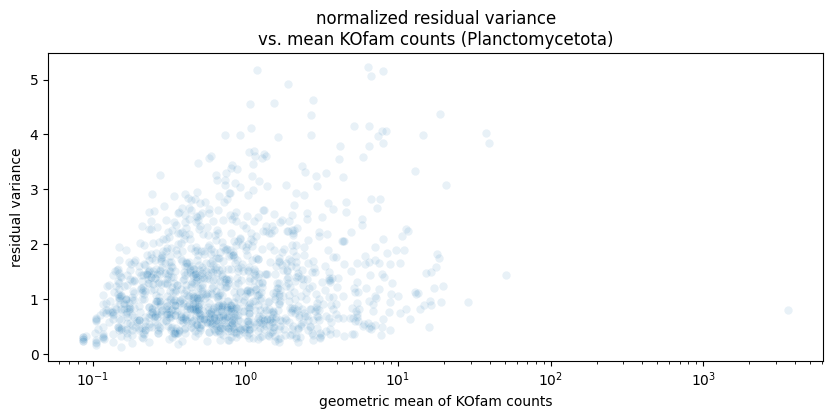

Normalizing slab 87 of 105: Platyhelminthes (28 samples, 267 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 267

R[write to console]: Total overdispersed genes: 267

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 267 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 267 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 11 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 267 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5340629 secs



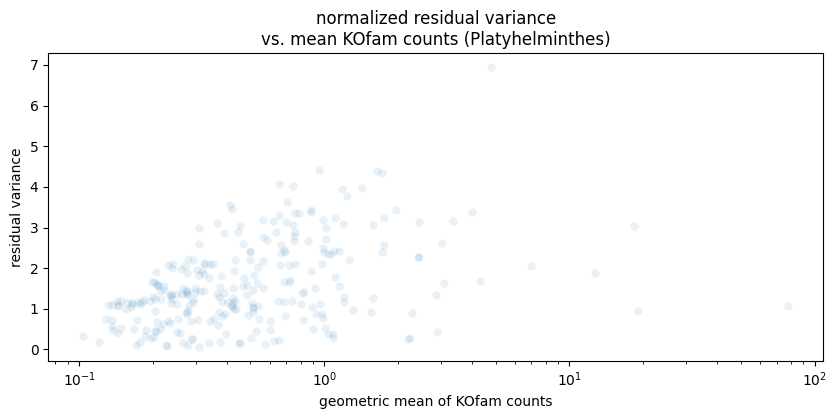

Normalizing slab 88 of 105: Porifera (28 samples, 611 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 611

R[write to console]: Total overdispersed genes: 611

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 611 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 611 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 38 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1.167685554025

R[write to console]: Second step: Get residuals using fitted parameters for 611 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.8281729 secs



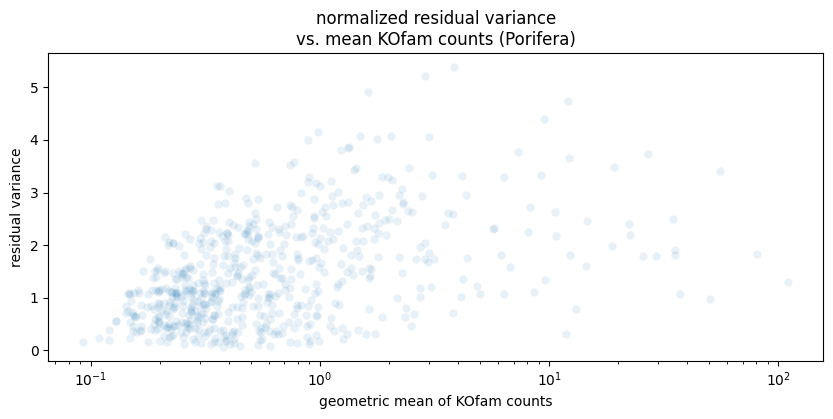

Normalizing slab 89 of 105: Prasinodermophyta (28 samples, 1379 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 1379

R[write to console]: Total overdispersed genes: 1378

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 1379 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 1378 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  8 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 131 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 1379 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.40241 secs



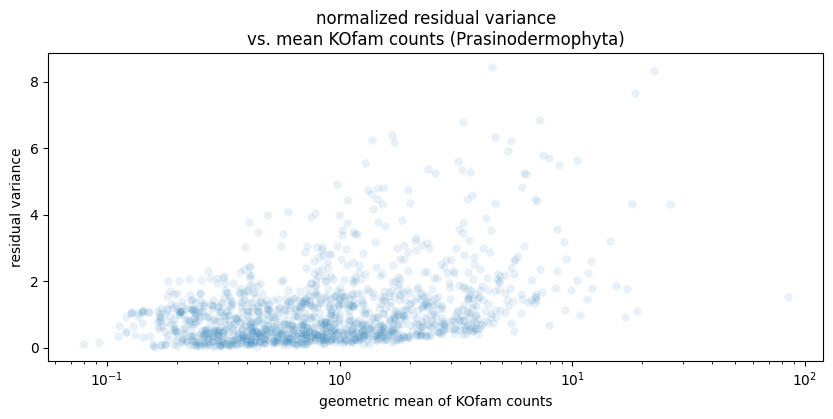

Normalizing slab 90 of 105: Pseudomonadota (25 samples, 11113 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 11113

R[write to console]: Total overdispersed genes: 11101

R[write to console]: Excluding 12 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 11113 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  5 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 38 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  15.441017404036

R[write to console]: Second step: Get residuals using fitted parameters for 11113 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.310536 secs



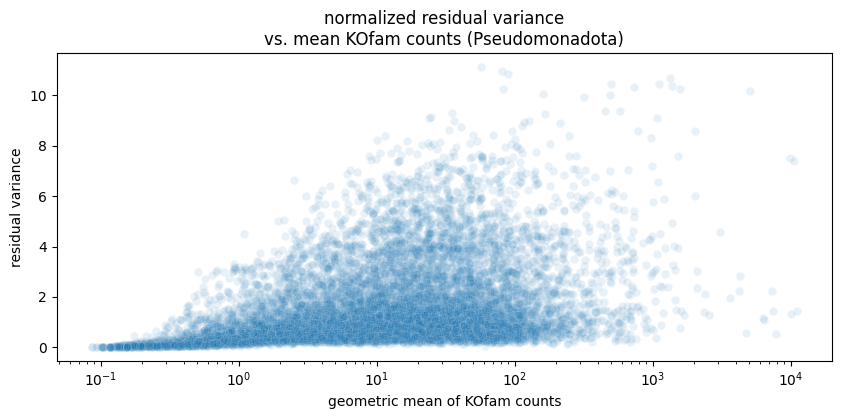

Normalizing slab 91 of 105: Raphidophyceae (28 samples, 842 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 842

R[write to console]: Total overdispersed genes: 841

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 842 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 841 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 35 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1.240670733316

R[write to console]: Second step: Get residuals using fitted parameters for 842 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.9966571 secs



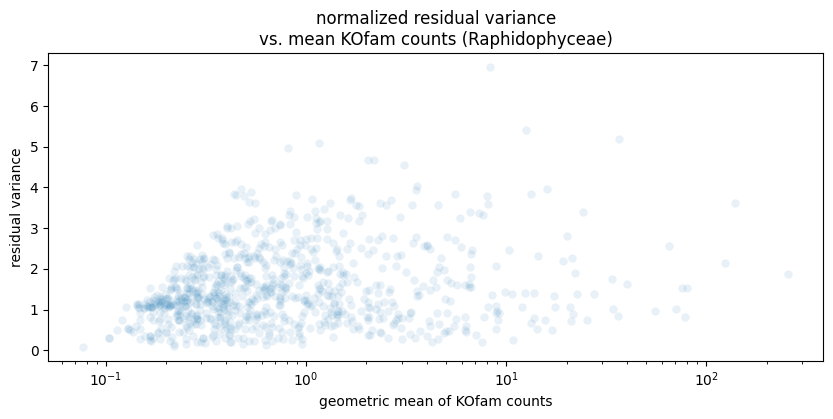

Normalizing slab 92 of 105: Rhodophyta (28 samples, 584 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 584

R[write to console]: Total overdispersed genes: 583

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 584 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 583 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 19 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.998296725904

R[write to console]: Second step: Get residuals using fitted parameters for 584 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.791683 secs



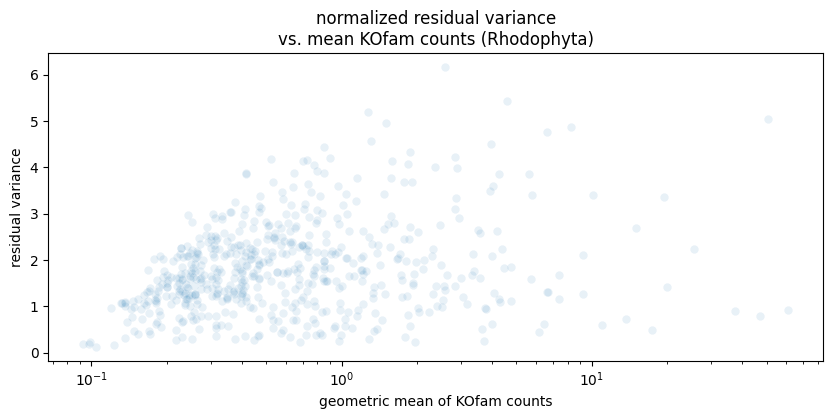

Normalizing slab 93 of 105: Rhodothermota (25 samples, 94 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 94

R[write to console]: Total overdispersed genes: 92

R[write to console]: Excluding 2 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 94 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 92 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 4 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 94 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.400521 secs



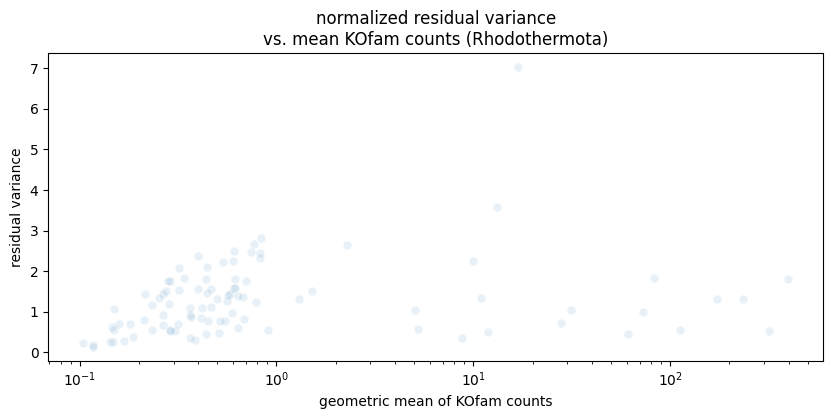

Normalizing slab 94 of 105: Rotifera (28 samples, 609 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 609

R[write to console]: Total overdispersed genes: 609

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 609 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 609 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  3 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 24 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 609 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.8713191 secs



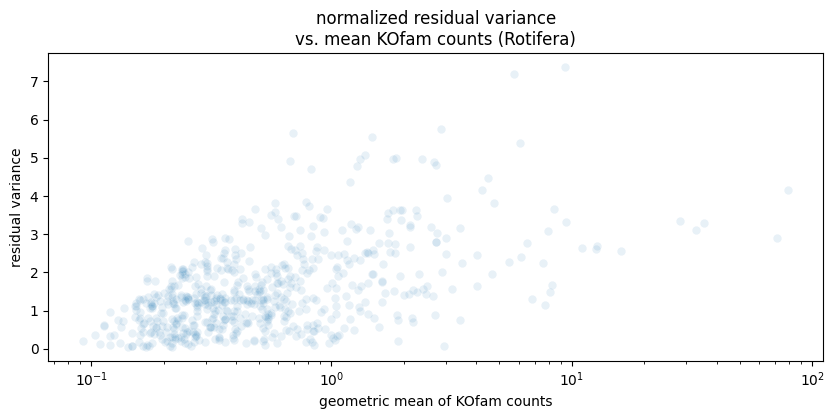

Normalizing slab 95 of 105: Spirochaetota (25 samples, 384 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 384

R[write to console]: Total overdispersed genes: 377

R[write to console]: Excluding 7 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 384 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 377 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  6 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 29 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.16

R[write to console]: Second step: Get residuals using fitted parameters for 384 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.6067309 secs



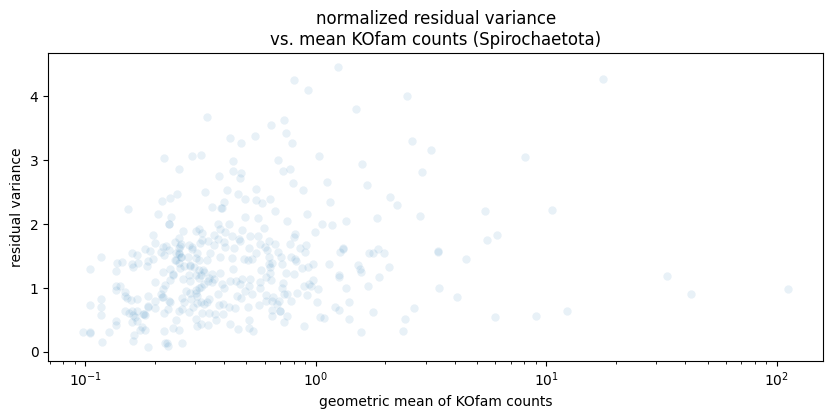

Normalizing slab 96 of 105: Streptophyta (28 samples, 834 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 834

R[write to console]: Total overdispersed genes: 834

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 834 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 834 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 49 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 834 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.9815509 secs



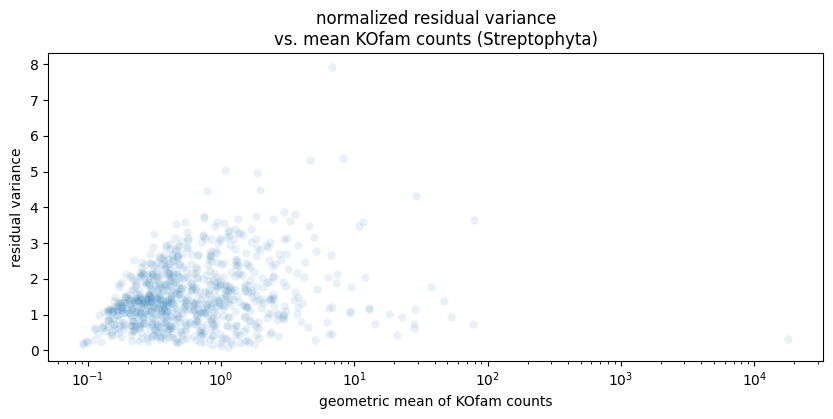

Normalizing slab 97 of 105: Synchromophyceae (28 samples, 146 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 146

R[write to console]: Total overdispersed genes: 146

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 146 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 146 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 3 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 146 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.4635999 secs



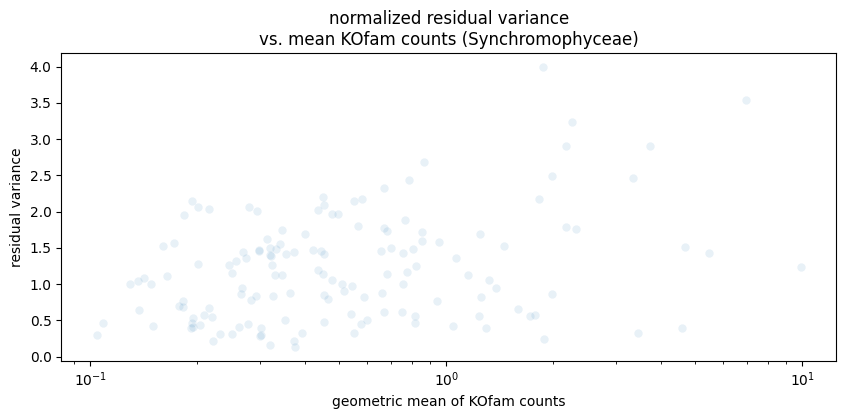

Normalizing slab 98 of 105: Synergistota (25 samples, 43 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 43

R[write to console]: Total overdispersed genes: 43

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 43 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 43 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 5 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.262916664516

R[write to console]: Second step: Get residuals using fitted parameters for 43 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.369889 secs



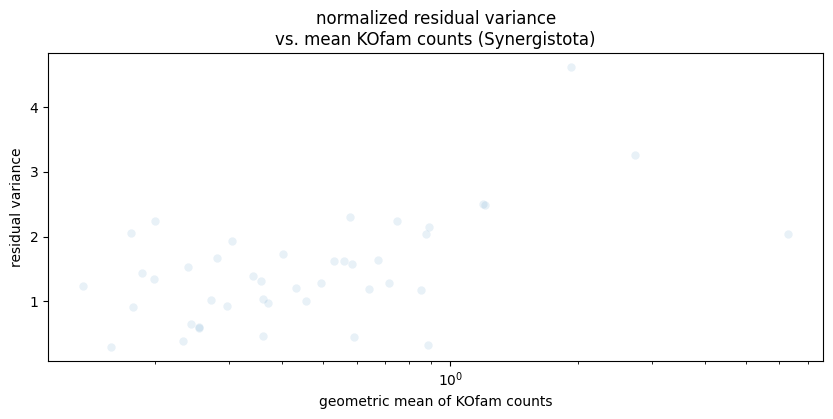

Normalizing slab 99 of 105: Synurophyceae (28 samples, 1022 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 1022

R[write to console]: Total overdispersed genes: 1022

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 1022 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 1022 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 23 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1.582345115569

R[write to console]: Second step: Get residuals using fitted parameters for 1022 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.120718 secs



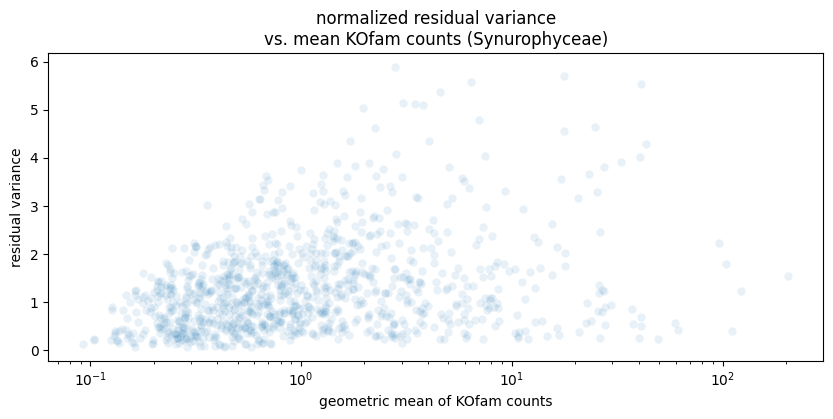

Normalizing slab 100 of 105: Thermodesulfobacteriota (25 samples, 939 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 939

R[write to console]: Total overdispersed genes: 933

R[write to console]: Excluding 6 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 939 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 933 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  5 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 46 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 939 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.017679 secs



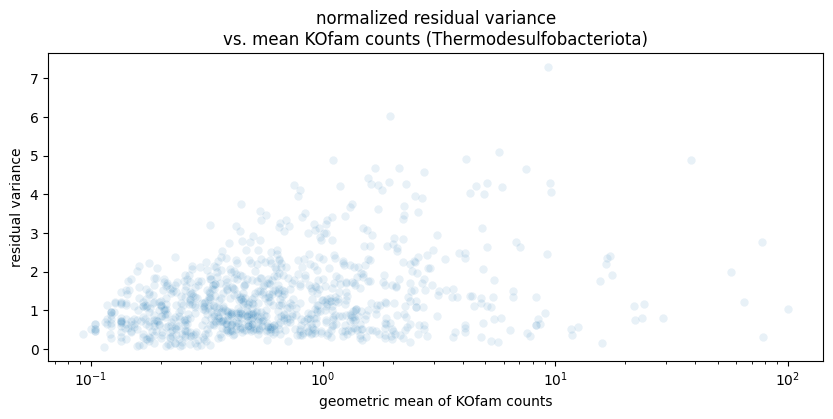

Skipping slab 101 of 105: Thermodesulfobiota (17 samples, 6 genes)
	Limited nonzero data in this slab undermines the reliability of normalization with sctransform.
Normalizing slab 102 of 105: Thermomicrobiota (25 samples, 79 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 79

R[write to console]: Total overdispersed genes: 79

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 79 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 79 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 5 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.532713136384

R[write to console]: Second step: Get residuals using fitted parameters for 79 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.386714 secs



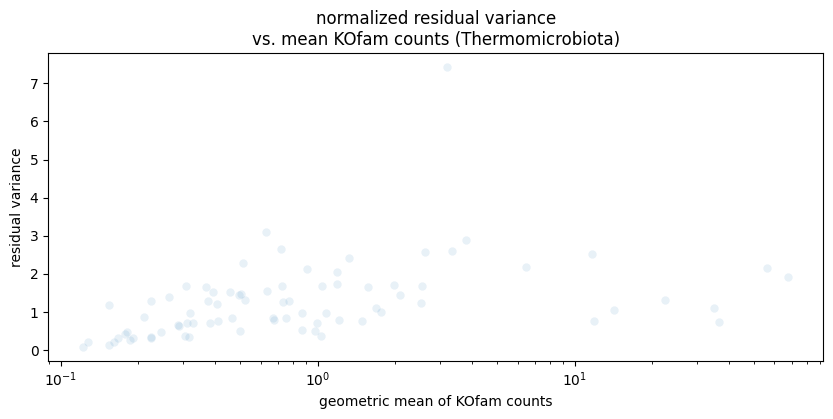

Normalizing slab 103 of 105: Thermotogota (25 samples, 63 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 63

R[write to console]: Total overdispersed genes: 61

R[write to console]: Excluding 2 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 63 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 61 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.2174543424

R[write to console]: Second step: Get residuals using fitted parameters for 63 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.374532 secs



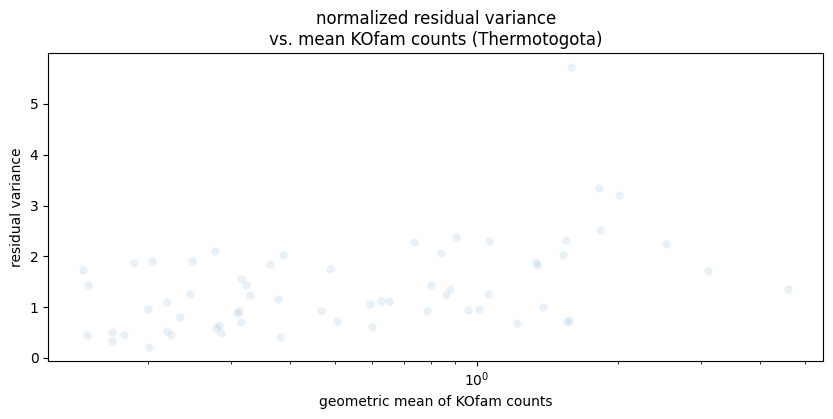

Normalizing slab 104 of 105: Verrucomicrobiota (25 samples, 3880 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 3880

R[write to console]: Total overdispersed genes: 3849

R[write to console]: Excluding 31 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 3880 by 25

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 25 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  33 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 128 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 3880 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.766788 secs



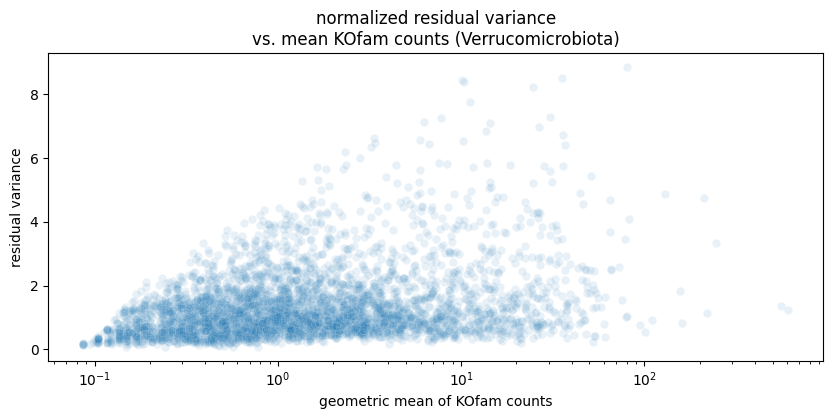

Normalizing slab 105 of 105: Xanthophyceae (28 samples, 147 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 147

R[write to console]: Total overdispersed genes: 147

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 147 by 28

R[write to console]: Model formula is y ~ (log_umi) : batch_id + batch_id + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 147 genes, 28 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 11 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch 1 -- assuming a low mean.

R[write to console]: Some genes not detected in batch 2 -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 147 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.467732 secs



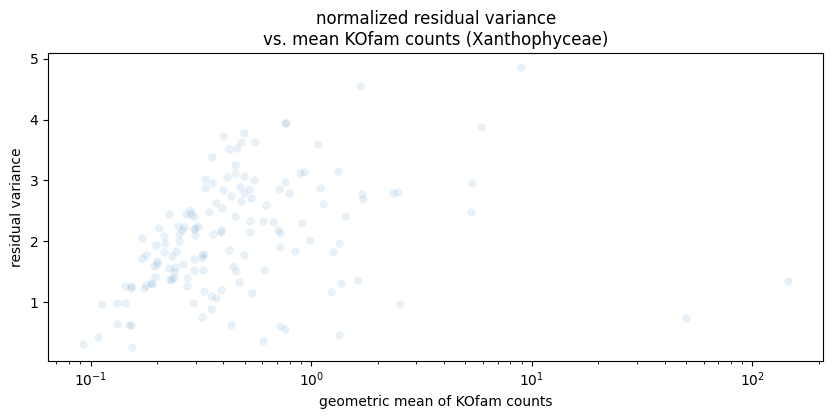

In [6]:
# run the model on each slab

# initialize residuals dataframe
residuals_df = pd.DataFrame()

# keep track of filtered data
dropped_data_df = pd.DataFrame()

# iterate through slabs
slab_ids = df[norm_mode].unique()
for i, slab_id in enumerate(slab_ids):
    # separate out data
    slab_df = df[df[norm_mode].eq(slab_id)].pivot(index=gene_mode, columns=['sample_rep_id'], values=data).fillna(0)
    # apply sample threshold to filter out low-prevalence genes
    slab_df, drop_df = sparsity_thold_df(slab_df, sample_thold, axis=1)
    drop_df = drop_df.melt(value_name=data, ignore_index=False).reset_index()
    drop_df[norm_mode] = slab_id
    drop_df['drop_reason'] = f'{gene_mode} detected in fewer than {sample_thold} {sample_mode}s'
    dropped_data_df = pd.concat([dropped_data_df, drop_df])
    # apply gene threshold to filter out samples with low detection
    slab_df, drop_df = sparsity_thold_df(slab_df, gene_thold, axis=0)
    drop_df = drop_df.melt(value_name=data, ignore_index=False).reset_index()
    drop_df[norm_mode] = slab_id
    drop_df['drop_reason'] = f'{sample_mode} contains fewer than {math.ceil(slab_df.shape[0] * gene_thold)} nonzero {gene_mode}s'
    dropped_data_df = pd.concat([dropped_data_df, drop_df])
    # check for very small slabs
    if (slab_df.shape[0] < 10) or (slab_df.shape[1] < sample_thold):
        print(f'Skipping slab {i+1} of {len(slab_ids)}: {slab_id} ({slab_df.shape[1]} samples, {slab_df.shape[0]} genes)', flush=True)
        print('\tLimited nonzero data in this slab undermines the reliability of normalization with sctransform.', flush=True)
        drop_df = slab_df.melt(value_name=data, ignore_index=False).reset_index()
        drop_df[norm_mode] = slab_id
        drop_df['drop_reason'] = f'{norm_mode} encompassed fewer than 10 {gene_mode}s or fewer than {sample_thold} {sample_mode}s'
        dropped_data_df = pd.concat([dropped_data_df, drop_df])
        continue
    else:
        print(f'Normalizing slab {i+1} of {len(slab_ids)}: {slab_id} ({slab_df.shape[1]} samples, {slab_df.shape[0]} genes)', flush=True)

    # make r version of slab dataframe
    r_slab_df = pandas_dataframe_to_r_matrix(slab_df)
    # pull out batch information
    if correction:
        sample_attr_df = meta_df.set_index('sample_rep_id').loc[slab_df.columns, [sample_mode, rep, batch_id]]
        r_sample_attr_df = pandas2ri.py2rpy(sample_attr_df)

    # fit vst normalization model
    if correction:
        result = sctransform.vst(
            r_slab_df, cell_attr=r_sample_attr_df, batch_var=ro.vectors.StrVector([batch_id]), 
            min_cells=sample_thold, vst_flavor='v2', verbosity=2
        )
    else:
        result = sctransform.vst(
            r_slab_df, min_cells=sample_thold, vst_flavor='v2', verbosity=2
        )

    # convert residuals result to a dataframe
    result_df = pd.DataFrame(
        np.asarray(result[0]), 
        index=slab_df.index, 
        columns=slab_df.columns
    )

    # prepare to save requested outputs
    if save_data or save_plots:
        # make unique output directory per slab
        dir_path = f'{outdir}/{slab_id}'
        if not os.path.isdir(dir_path):
            os.makedirs(dir_path)
        # calculate residuals
        residual_var = result_df.var(axis=1)

    # save data if requested
    if save_data:
        # save csv of residuals
        result_df.to_csv(f'{dir_path}/residuals_{slab_id}.csv')
        # save csv of residual variances
        res_var_df = residual_var.reset_index().rename(columns={0:'residual_variance'})
        res_var_df = res_var_df.sort_values('residual_variance', ascending=False).reset_index()
        res_var_df.to_csv(f'{dir_path}/residual_variances_{slab_id}.csv')

    # save plots if requested
    if save_plots:
        # plots of model parameters
        plots = sctransform.plot_model_pars(result, show_theta=True)
        img = image_png(plots)
        with open(f'{dir_path}/parameters_{slab_id}.png', 'wb') as png:
            png.write(img.data)
        # plot of high variance genes
        means = slab_df.apply(geometric_mean, axis=1)
        plt.figure(figsize=(10, 4))
        sns.scatterplot(x=means, y=residual_var, alpha=0.1);
        plt.xlabel(f'geometric mean of {gene_mode} {data}')
        plt.xscale('log')
        plt.ylabel('residual variance')
        plt.title(f'normalized residual variance\nvs. mean {gene_mode} {data} ({slab_id})')
        plt.savefig(f'{dir_path}/residual_variances_{slab_id}.png')
        plt.show()

    # concatenate result with other residuals
    result_df = result_df.melt(value_name='residual', ignore_index=False).reset_index()
    result_df[norm_mode] = slab_id
    residuals_df = pd.concat([residuals_df, result_df])
        

In [7]:
# save normalized data as a csv

# add back sample information
residuals_df = pd.merge(residuals_df, df[['sample_rep_id', sample_mode, rep]].drop_duplicates(), on='sample_rep_id', how='left')

# add in raw count data
residuals_df = pd.merge(residuals_df, df, on=['sample_rep_id', mode0, mode1, mode2, rep], how='left').fillna(0)

# tidy up dataframe
residuals_df = residuals_df[[mode0, mode1, mode2, rep, data, 'residual']]

# save output
residuals_df.to_csv(f'{outdir}/normalized-residuals.csv')

residuals_df


KOfam           phylum      sample_name replicate  counts  \
0        K00052  Acidobacteriota  G3.UW.ALL.L25S1         A     0.0   
1        K00067  Acidobacteriota  G3.UW.ALL.L25S1         A     0.0   
2        K00070  Acidobacteriota  G3.UW.ALL.L25S1         A     4.0   
3        K00134  Acidobacteriota  G3.UW.ALL.L25S1         A     0.0   
4        K00299  Acidobacteriota  G3.UW.ALL.L25S1         A     0.0   
...         ...              ...              ...       ...     ...   
4393845  K25458    Xanthophyceae  G3.UW.ALL.L40S2         C     0.0   
4393846  K25547    Xanthophyceae  G3.UW.ALL.L40S2         C     0.0   
4393847  K25549    Xanthophyceae  G3.UW.ALL.L40S2         C     0.0   
4393848  K25866    Xanthophyceae  G3.UW.ALL.L40S2         C     0.0   
4393849  K26163    Xanthophyceae  G3.UW.ALL.L40S2         C     0.0   

             residual  
0       -4.553487e-01  
1       -4.228747e-01  
2        1.541181e+00  
3       -4.193130e-01  
4       -4.768250e-01  
...               ...  
4393845 -1.156521e-01  
4393846 -3.732466e-02  
4393847 -1.290809e-13  
4393848 -7.694060e-02  
4393849 -1.291784e-01  

[4393850 rows x 6 columns]

In [8]:
# examine data that was removed during normalization process

# remove zero values
dropped_data_df = dropped_data_df[dropped_data_df[data] != 0.0]

# add back sample information
dropped_data_df = pd.merge(dropped_data_df, df[['sample_rep_id', sample_mode, rep]].drop_duplicates(), on='sample_rep_id', how='left')

# tidy up dataframe
dropped_data_df = dropped_data_df[[mode0, mode1, mode2, rep, data, 'drop_reason']]

# show some summary statistics
for variable in ['drop_reason', mode0, mode1, mode2]:
    print(dropped_data_df[variable].value_counts())

# save drop data
dropped_data_df.to_csv(f'{outdir}/removed-data.csv')      

dropped_data_df


drop_reason
KOfam detected in fewer than 3 sample_names                             17698
phylum encompassed fewer than 10 KOfams or fewer than 3 sample_names      238
Name: count, dtype: int64
KOfam
K09760    29
K02655    18
K06240    18
K20777    17
K02349    16
          ..
K05896     1
K07855     1
K07426     1
K25557     1
K15272     1
Name: count, Length: 7752, dtype: int64
phylum
Mollusca                       1487
Cyanobacteriota                 717
Echinodermata                   635
Annelida                        622
Brachiopoda                     622
                               ... 
Atribacterota                     2
Candidatus-Hydrogenedentota       2
Candidatus-Latescibacterota       2
Fornicata                         2
Elusimicrobiota                   1
Name: count, Length: 105, dtype: int64
sample_name
G3.UW.ALL.L40S1    3258
G3.UW.ALL.L35S2    2284
G3.UW.ALL.L40S2    2270
G3.UW.ALL.L25S1    1731
G3.UW.ALL.L37S1    1503
G3.UW.ALL.L35S1    1477
G3.UW.ALL.L32S1    

KOfam           phylum      sample_name replicate    counts  \
0      K00078  Acidobacteriota  G3.UW.ALL.L25S1         A   5.83841   
1      K00412  Acidobacteriota  G3.UW.ALL.L25S1         A  12.59982   
2      K01219  Acidobacteriota  G3.UW.ALL.L25S1         A   1.00000   
3      K03530  Acidobacteriota  G3.UW.ALL.L25S1         A   8.00000   
4      K05541  Acidobacteriota  G3.UW.ALL.L25S1         A   1.00000   
...       ...              ...              ...       ...       ...   
17931  K05765    Xanthophyceae  G3.UW.ALL.L40S2         A   6.00000   
17932  K09585    Xanthophyceae  G3.UW.ALL.L40S2         A  14.00000   
17933  K13088    Xanthophyceae  G3.UW.ALL.L40S2         A   9.07489   
17934  K13088    Xanthophyceae  G3.UW.ALL.L40S2         B   1.37463   
17935  K09585    Xanthophyceae  G3.UW.ALL.L40S2         C  13.00000   

                                       drop_reason  
0      KOfam detected in fewer than 3 sample_names  
1      KOfam detected in fewer than 3 sample_names  
2      KOfam detected in fewer than 3 sample_names  
3      KOfam detected in fewer than 3 sample_names  
4      KOfam detected in fewer than 3 sample_names  
...                                            ...  
17931  KOfam detected in fewer than 3 sample_names  
17932  KOfam detected in fewer than 3 sample_names  
17933  KOfam detected in fewer than 3 sample_names  
17934  KOfam detected in fewer than 3 sample_names  
17935  KOfam detected in fewer than 3 sample_names  

[17936 rows x 6 columns]